<a href="https://colab.research.google.com/github/esemsc-ahk120/ci_mpm/blob/master/locationtime_combine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycm livelossplot torchinfo -q
!pip install scikit-image -q

%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from livelossplot import PlotLosses

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from tqdm import tqdm
import random
import cv2
from sklearn.preprocessing import MinMaxScaler
from skimage.transform import resize
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchinfo import summary
import torchvision
from torchvision import transforms

import h5py, IPython, PIL, os, io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.6/608.6 kB 15.8 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="train.h5", repo_type="dataset", local_dir="data")
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="events.csv", repo_type="dataset", local_dir="data")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.h5:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

events.csv:   0%|          | 0.00/782k [00:00<?, ?B/s]

'data/events.csv'

In [4]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

Cuda installed! Running on GPU 0 NVIDIA A100-SXM4-40GB!


In [5]:
df = pd.read_csv("data/events.csv", parse_dates=["start_utc"])
print(f"Total number of events: {len(df.id.unique())}")
id_list = df.id.unique()

Total number of events: 800


In [6]:
# this function loads all of the image arrays for a given id
def load_event(id):
    "Load event"
    with h5py.File(f'data/train.h5','r') as f:
        event = {img_type: f[id][img_type][:] for img_type in ['vis', 'ir069', 'ir107', 'vil', 'lght']}
    return event

event = load_event("S778114")
for img_type in event:
    print(f"{img_type}: {event[img_type].shape} ({event[img_type].dtype})")

# these functions will plot an event

def make_gif(outfile, files, fps=10, loop=0):
    "Helper function for saving GIFs"
    imgs = [PIL.Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='gif', append_images=imgs[1:],
                 save_all=True, duration=int(1000/fps), loop=loop)
    im = IPython.display.Image(filename=outfile)
    im.reload()
    return im

def plot_event(id, output_gif=False, save_gif=False):
    "Helper function for plotting an event"
    event = load_event(id)
    t = event["lght"][:,0]# time of lightning strike (in seconds relative to first frame)
    def plot_frame(ti):
        f = (t >= ti*5*60 - 2.5*60) & (t < ti*5*60 + 2.5*60)# find which lightning strikes fall in current frame
        fig,axs = plt.subplots(1,4,figsize=(16,4))
        fig.suptitle(f"Event: {id}, Frame: {ti}, Time: {ti*5} min")
        axs[0].imshow(event["vis"][:,:,ti], vmin=0, vmax=10000, cmap="grey"), axs[0].set_title('Visible')
        axs[1].imshow(event["ir069"][:,:,ti], vmin=-8000, vmax=-1000, cmap="viridis"), axs[1].set_title('Infrared (Water Vapor)')
        axs[2].imshow(event["ir107"][:,:,ti], vmin=-7000, vmax=2000, cmap="inferno"), axs[2].set_title('Infrared (Cloud/Surface Temperature)')
        axs[3].imshow(event["vil"][:,:,ti], vmin=0, vmax=255, cmap="turbo"), axs[3].set_title('Radar (Vertically Integrated Liquid)')
        axs[3].scatter(event["lght"][f,3], event["lght"][f,4], marker="x", s=30, c="tab:red")
        axs[3].set_xlim(0,384), axs[3].set_ylim(384,0)
        if output_gif:
            file = f"_temp_{id}_{ti}.png"
            fig.savefig(file, bbox_inches="tight", dpi=150, pad_inches=0.02, facecolor="white")
            plt.close()
        else:
            plt.show()
    if output_gif:
        for ti in range(36): plot_frame(ti)
        im = make_gif(f"{id}.gif", [f"_temp_{id}_{ti}.png" for ti in range(36)])
        for ti in range(36): os.remove(f"_temp_{id}_{ti}.png")
        IPython.display.display(im)
        if not save_gif: os.remove(f"{id}.gif")
    else:
        plot_frame(0)
        plot_frame(17)
        plot_frame(34)

vis: (384, 384, 36) (int16)
ir069: (192, 192, 36) (int16)
ir107: (192, 192, 36) (int16)
vil: (384, 384, 36) (uint8)
lght: (38777, 5) (float32)


# Task 3
For this task there are 3 variables that needed to be prediced:
- Number of flashes
- Location of the flashes
- The time when the flashes occur

The process that will be used to predicts the events consists of 2 parts:
-  a model that predicts the locations and number of strikes over each 5 minutes frame
- a model that distributes the the lightning results of each frame into a time series


## Image preprocessing
To set up the model, the images that are given will have to be preprocessed. The preprocessing are as follow:

1. Normlise the data in a range(0, 1)
2. Scale the images down from (384 x 384) to (192 x 192) - to reduce the memeory usage
3. Turn the lightning locations into grid form (384 x 384) and scale down to (192 x 192)

The following is an example preprocessing process for one the images:

In [7]:
def norm_img(img_over_time):
    """
    Normalize each image in a time sequence using sklearn's MinMaxScaler.

    Args:
    - img_over_time: 3D NumPy array of shape (time_steps, height, width)

    Returns:
    - normalized_images: 3D NumPy array of normalized images with the same shape as input
    """
    scaler = MinMaxScaler()  # Initialize MinMaxScaler
    normalized_images = []  # List to store normalized images

    # Normalize each frame (time slice)
    for i in range(img_over_time.shape[0]):
        img = img_over_time[i]
        img_flat = img.reshape(-1, 1)  # Flatten image to 2D array (required by MinMaxScaler)
        normalized_img_flat = scaler.fit_transform(img_flat)  # Apply Min-Max scaling
        normalized_img = normalized_img_flat.reshape(img.shape)  # Reshape back to original dimensions
        normalized_images.append(normalized_img)

    return np.array(normalized_images)  # Return normalized images as a NumPy array


# Function to downscale images
def downscale_img(img_over_time, target_shape=(192, 192)):
    """
    Downscale each frame (spatial dimensions) in the input sequence of images.

    Parameters:
    - img_over_time (numpy array): Input images of shape (height, width, time).
    - target_shape (tuple): The target shape for each frame (height, width).

    Returns:
    - numpy array: Downscaled images of shape (target_height, target_width, time).
    """
    # Extract the temporal dimension
    height, width, time = img_over_time.shape

    # Initialize an array for the downscaled output
    downscaled_images = np.empty((target_shape[0], target_shape[1], time), dtype=np.float32)

    # Downscale each frame (slice along the temporal dimension)
    for t in range(time):
        frame = img_over_time[:, :, t]  # Extract the t-th frame
        downscaled_frame = resize(frame, target_shape, mode='reflect', anti_aliasing=True)
        downscaled_images[:, :, t] = downscaled_frame  # Store the downscaled frame

    return downscaled_images


def image_show(train, title, image_no = False):
  if image_no == False:
    x = np.random.randint(0, train[title].shape[2])
  else:
    x = image_no
  test = train[title][:,:,x]
  print(test.shape)
  print(test)
  plt.imshow(test, cmap="turbo")
  plt.colorbar(label="Intensity")
  plt.show()

def tensor_image_show(test):
  print(test.shape)
  print(test)
  plt.imshow(test, cmap="turbo")
  plt.colorbar(label="Intensity")
  plt.show()

def dataset_image_show(dataset, i, time_step=0):
    """
    Plot the 4 images (channels) for a specific storm at a given time step.

    Args:
    - dataset: The dataset containing input tensors.
    - i: Index of the storm in the dataset.
    - time_step: The time step to visualize (default is 0).
    """
    # Extract the inputs tensor for the specified storm
    inputs = dataset[i][0]  # Shape: (4, time_steps, height, width)

    # Titles for the channels
    titles = ["Visible (vis)", "Infrared (ir069)", "Infrared (ir107)", "Radar (vil)"]

    # Create a figure with 4 subplots
    plt.figure(figsize=(16, 8))
    for channel in range(4):
        plt.subplot(1, 4, channel + 1)  # Create a subplot for each channel
        plt.imshow(inputs[channel, time_step, :, :].cpu().numpy(), cmap="turbo")  # Convert tensor to NumPy array
        plt.title(titles[channel])
        plt.colorbar(label="Intensity")
        plt.axis("off")  # Turn off axes for clarity

    # Show the plots
    plt.tight_layout()
    plt.show()


def dataset_image_and_lightning_show(dataset, i, time_step=0):
    """
    Plot the 4 images (channels) and the lightning strikes for a specific storm at a given time step.

    Args:
    - dataset: The dataset containing input tensors and label tensors.
    - i: Index of the storm in the dataset.
    - time_step: The time step to visualize (default is 0).
    """
    # Extract the inputs tensor and labels for the specified storm
    inputs = dataset[i][0]  # Inputs: Shape (4, time_steps, height, width)
    labels = dataset[i][1]  # Labels: Shape (time_steps, height, width)

    # Titles for the channels
    titles = ["Visible (vis)", "Infrared (ir069)", "Infrared (ir107)", "Radar (vil)"]

    # Create a figure with 5 subplots (4 for channels, 1 for lightning)
    plt.figure(figsize=(20, 8))

    # Plot the 4 channels
    for channel in range(4):
        plt.subplot(1, 5, channel + 1)  # Create a subplot for each channel
        plt.imshow(inputs[channel, time_step, :, :].cpu().numpy(), cmap="turbo")  # Convert tensor to NumPy array
        plt.title(titles[channel])
        plt.colorbar(label="Intensity")
        #plt.axis("off")

    # Plot the lightning strikes (binary heatmap)
    plt.subplot(1, 5, 5)
    label_map = labels[time_step].cpu().numpy()  # Convert label tensor to NumPy array
    y_coords, x_coords = np.where(label_map == 1)  # Extract coordinates of lightning strikes
    plt.imshow(label_map, cmap="Greys", alpha=0.8)  # Show the label map
    plt.scatter(x_coords, y_coords, c="red", s=10, label="Lightning Strikes")  # Overlay lightning strikes
    plt.title("Lightning Strikes")
    plt.legend()
    #plt.colorbar(label="Strike Intensity")
    #plt.axis("off")

    # Show the plots
    plt.tight_layout()
    plt.show()



def generate_labels(event, height=192, width=192, num_frames=36):
  """
  Generate binary labels for lightning locations for a given event.
  """
  t = event["lght"][:, 0]  # Time of lightning strikes
  x_coords = event["lght"][:, 3]  # X-coordinates of strikes
  y_coords = event["lght"][:, 4]  # Y-coordinates of strikes
  labels = np.zeros((num_frames, height, width), dtype=np.float32)

  # Fixed interval length: 5 minutes (300 seconds)
  frame_duration = 5 * 60

  for ti in range(num_frames):
      # Calculate the start and end time for the current frame
      frame_start = ti * frame_duration
      frame_end = (ti + 1) * frame_duration

      # Find the strikes in the current frame
      strikes_in_frame = (t >= frame_start) & (t < frame_end)

      # Populate the label map
      for x, y in zip(x_coords[strikes_in_frame], y_coords[strikes_in_frame]):
          x_pixel = int(x / 384 * width)  # Scale x to match resolution
          y_pixel = int(y / 384 * height)  # Scale y to match resolution
          labels[ti, y_pixel, x_pixel] = 1  # Set the pixel value to 1

  return labels


  import matplotlib.pyplot as plt

def plot_label_scatter(label_tensor, time_step, title="Scatter Plot of Lightning Strikes"):
    """
    Plots a scatter plot for a specific time step of the label tensor.

    Parameters:
    - label_tensor (torch.Tensor or np.array): Label tensor of shape (time_steps, height, width).
    - time_step (int): The time step to visualize.
    - title (str): Title for the plot.
    """
    # Get the label map for the specified time step
    label_map = label_tensor[time_step]  # Shape: (height, width)

    # Get coordinates of lightning strikes (locations where value is 1)
    y_coords, x_coords = (label_map == 1).nonzero(as_tuple=True) if isinstance(label_tensor, torch.Tensor) else np.where(label_map == 1)

    # Create the scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(x_coords, y_coords, c="red", label="Lightning Strikes", s=20)
    plt.gca().invert_yaxis()  # Invert the y-axis to match image coordinates
    plt.title(f"{title} (Time Step {time_step})")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
dataset = []  # List to store processed events
storm_no = 1
for storm_id in id_list[0:2]:
    print(f"{storm_no}. Processing storm: {storm_id}")
    event = load_event(storm_id)
    storm_no += 1
    # Process inputs
    inputs = []
    for title in ['vis', 'ir069', 'ir107', 'vil']:
        normalized_img = norm_img(event[title])  # Normalize images
        if title in ['vis', 'vil']:
            processed_img = downscale_img(normalized_img, target_shape=(192, 192))  # Downscale if needed
        else:
            processed_img = normalized_img

        # Append processed_img to the list (time_steps, height, width)
        inputs.append(processed_img)

    # Stack all inputs along the channel dimension
    inputs_tensor = np.stack(inputs, axis=0)  # (channels, time_steps, height, width)

    # Reorder dimensions to (channels, time_steps, height, width)
    inputs_tensor = np.transpose(inputs_tensor, (0, 3, 1, 2))  # Fix the order of dimensions
    inputs_tensor = torch.tensor(inputs_tensor, dtype=torch.float32)

    # Process labels
    labels = generate_labels(event, height=192, width=192, num_frames=36)  # Generate binary labels
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    # Append (input, label) pair to the dataset
    dataset.append((inputs_tensor, labels_tensor))
print(f"Processed {len(dataset)} storms.")

1. Processing storm: S778114
2. Processing storm: S767475
Processed 2 storms.


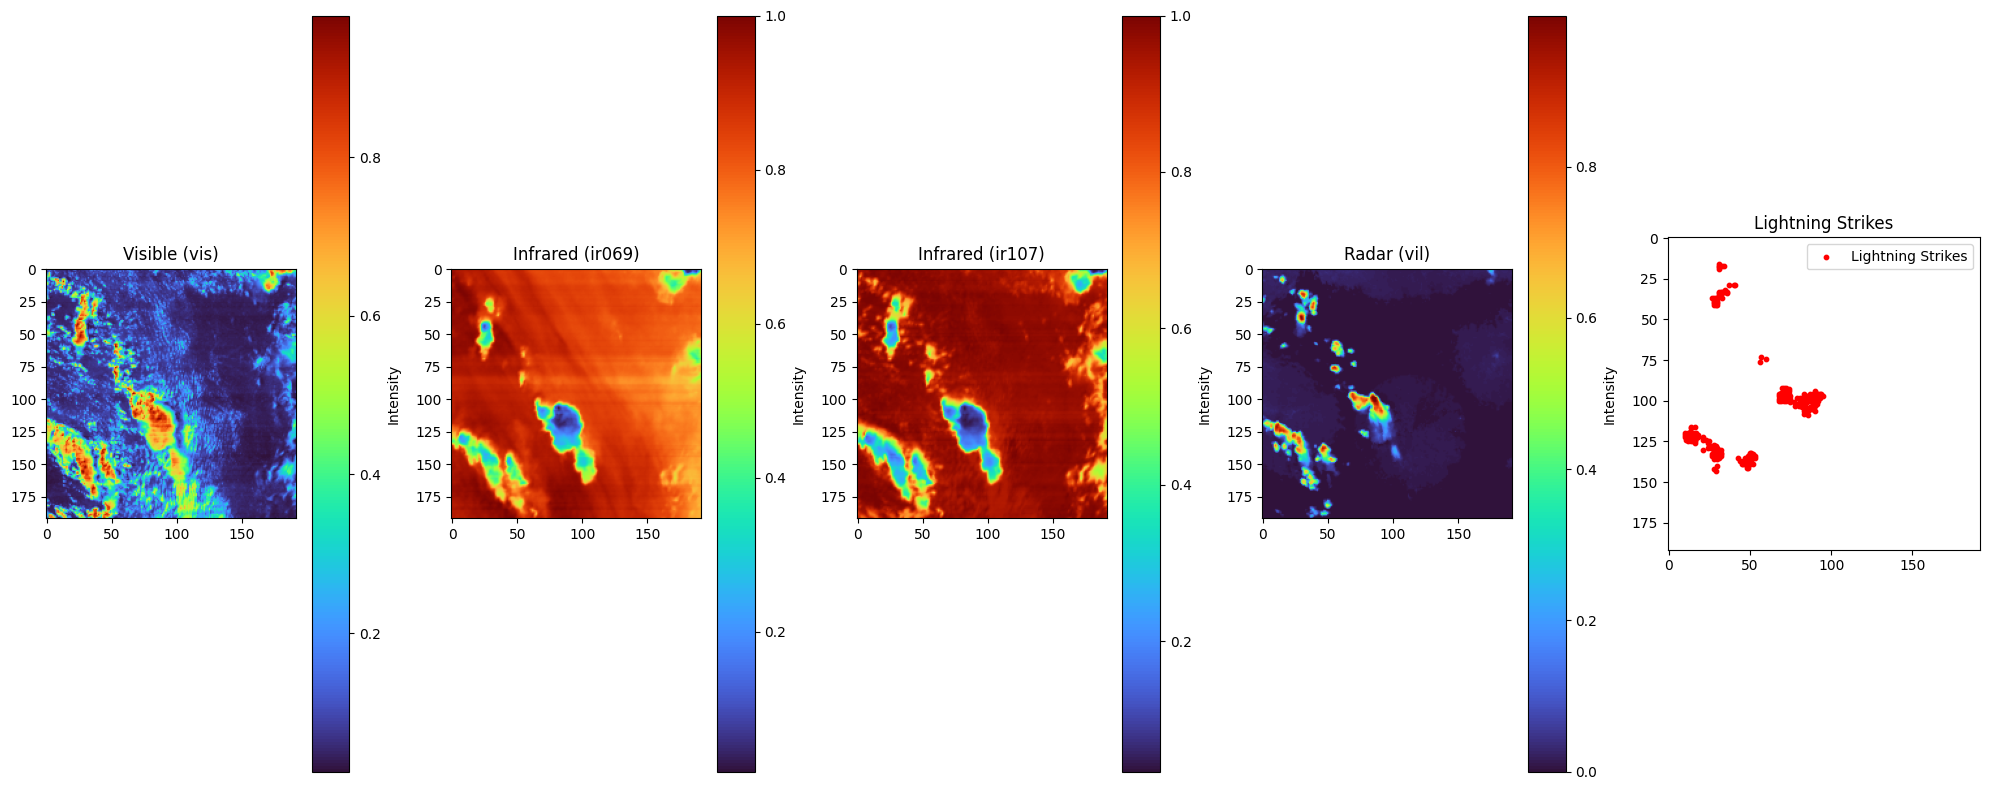

In [9]:
dataset_image_and_lightning_show(dataset, i=0, time_step=0)

For this model, we will first only use the Vil band to predic the lightning strikes - downloading the images that are already preprocessed from drive:

In [10]:
# # load and test npy downsized vis
# vis_data = np.load('/content/drive/MyDrive/fay-downsized-imgs/downsized_vis.npy')
# print(vis_data.shape)

# # load and test npy downsized ir069
# ir069_data = np.load('/content/drive/MyDrive/fay-downsized-imgs/downsized_ir069.npy')
# print(ir069_data.shape)

# # load and test npy downsized ir107
# ir107_data = np.load('/content/drive/MyDrive/fay-downsized-imgs/downsized_ir107.npy')
# print(ir107_data.shape)

# load and test npy downsized vil
vil_data = np.load('/content/drive/MyDrive/fay-downsized-imgs/downsized_vil.npy')
print(vil_data.shape)

# load and test npy strike arrays
strike_data = np.load('/content/drive/MyDrive/fay-downsized-imgs/strike_array.npy')
print(strike_data.shape)

(800, 36, 192, 192)
(800, 36, 192, 192)


In [48]:
strike_data = torch.tensor(strike_data, dtype=torch.float32)
vil_data = torch.tensor(vil_data, dtype=torch.float32)

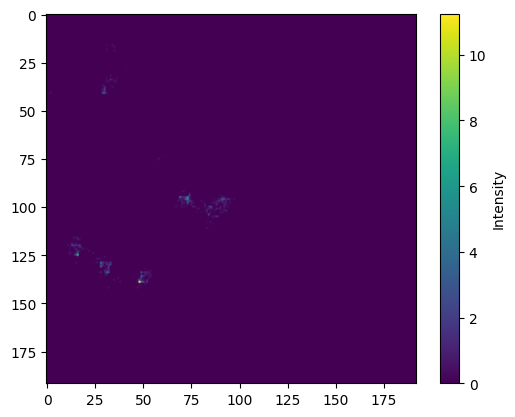

In [52]:
plt.imshow(strike_data[0][1])
plt.colorbar(label="Intensity")
plt.show()

## Location prediction:

First, create a class for the dataset:

In [47]:
# Define the dataset class
batch_size = 16
epochs = 30
num_events = 400
strike_threshold = 0.5

class LightningStrikeDataset(Dataset):
    def __init__(self, image_data, strike_data, transform=None):
        self.image_data = image_data  # Shape: (800, 36, 192, 192)
        self.strike_data = strike_data  # Shape: (800, 36, 192, 192)
        self.transform = transform

    def __len__(self):
        return len(self.image_data)  # 800 events

    def __getitem__(self, idx):
        # Load the VIL image data (36 frames of size 192x192)
        images = self.image_data[idx]  # Shape: (36, 192, 192)
        images = torch.tensor(images, dtype=torch.float32)  # Shape: [36, 192, 192]

        images = images.unsqueeze(0)  # Add a channel dimension to make it [1, 36, 192, 192]

        strikes = self.strike_data[idx]  # Shape: (36, 192, 192)
        strikes = torch.tensor(strikes, dtype=torch.float32)

        if self.transform:
            images = self.transform(images)
            strikes = self.transform(strikes)

        return images, strikes

# Split data into train/val/test (80/10/10 split)
train_idx, test_val_idx = train_test_split(range(num_events), test_size=0.2, shuffle=False)
val_idx, test_idx = train_test_split(test_val_idx, test_size=0.2, shuffle=False)
print(vil_data.shape, strike_data.shape)

# Create datasets for each split
train_dataset = LightningStrikeDataset(vil_data[train_idx], strike_data[train_idx])
val_dataset = LightningStrikeDataset(vil_data[val_idx], strike_data[val_idx])
test_dataset = LightningStrikeDataset(vil_data[test_idx], strike_data[test_idx])

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# del image_data, strike_data

(800, 36, 192, 192) (800, 36, 192, 192)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,

A 3DCNN network is used for this task.

In [39]:
# model
class SimpleLightningStrikeCNN3D(nn.Module):
    def __init__(self):
        super(SimpleLightningStrikeCNN3D, self).__init__()
        # Modify input channels to 1 (since we're testing with a single band)
        self.conv1 = nn.Conv3d(1, 16, kernel_size=(3, 3, 3), padding=(1, 1, 1))  # (input_channels, output_channels, kernel_size)
        #self.bn1 = nn.BatchNorm3d(16)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        # Remove gap layer
        #self.gap = nn.AdaptiveAvgPool3d((1, 1, 1))
        # Add new convolutional layers to recover the spatial dimensions
        self.conv3 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4 = nn.Conv3d(64, 1, kernel_size=(3, 3, 3), padding=(1, 1, 1)) # Output 1 channel

    def forward(self, x):
        # Forward pass through the convolutional layers
        x = F.relu(self.conv1(x))  # Apply ReLU activation after Conv1
        x = F.relu(self.conv2(x))  # Apply ReLU activation after Conv2
        # Remove global average pooling and fc layers
        #x = self.gap(x)  # Global average pooling
        #x = x.view(x.size(0), -1)  # Flatten the tensor
        #x = self.sigmoid(self.fc(x))  # Sigmoid activation to output values between 0 and 1
        x = F.relu(self.conv3(x))  # Apply ReLU activation after Conv3
        x = self.conv4(x)  # Apply Conv4
        # Reshape to match desired output size.
        x = x.view(x.size(0), 36, 192, 192)

        return x

# Instantiate the model and send to device if room
model = SimpleLightningStrikeCNN3D().to(device)
summary(model, input_size=(1, 36, 192, 192), batch_dim=0)


Layer (type:depth-idx)                   Output Shape              Param #
SimpleLightningStrikeCNN3D               [1, 36, 192, 192]         --
├─Conv3d: 1-1                            [1, 16, 36, 192, 192]     448
├─Conv3d: 1-2                            [1, 32, 36, 192, 192]     13,856
├─Conv3d: 1-3                            [1, 64, 36, 192, 192]     55,360
├─Conv3d: 1-4                            [1, 1, 36, 192, 192]      1,729
Total params: 71,393
Trainable params: 71,393
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 94.75
Input size (MB): 5.31
Forward/backward pass size (MB): 1199.70
Params size (MB): 0.29
Estimated Total Size (MB): 1205.30

In [9]:
def train(model, train_loader, optimizer, criterion, accumulation_steps=2): # Added accumulation_steps
    model.train()
    train_loss = 0.0
    optimizer.zero_grad() # Zero grad before the loop

    for i, (images, strikes) in enumerate(train_loader):
        images, strikes = images.to(device), strikes.to(device)
        outputs = model(images)
        loss = criterion(outputs, strikes)
        loss = loss / accumulation_steps # Scale loss
        loss.backward()

        if (i + 1) % accumulation_steps == 0:  # Update every accumulation_steps
            optimizer.step()  # Update model parameters using the accumulated gradients
            optimizer.zero_grad()  # Zero gradients for the next accumulation cycle

        train_loss += loss.item()
    train_loss /= len(train_loader)
    return train_loss

# validate
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():

        for images, strikes in val_loader:
            images, strikes = images.to(device), strikes.to(device)
            outputs = model(images)
            loss = criterion(outputs, strikes)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    return val_loss

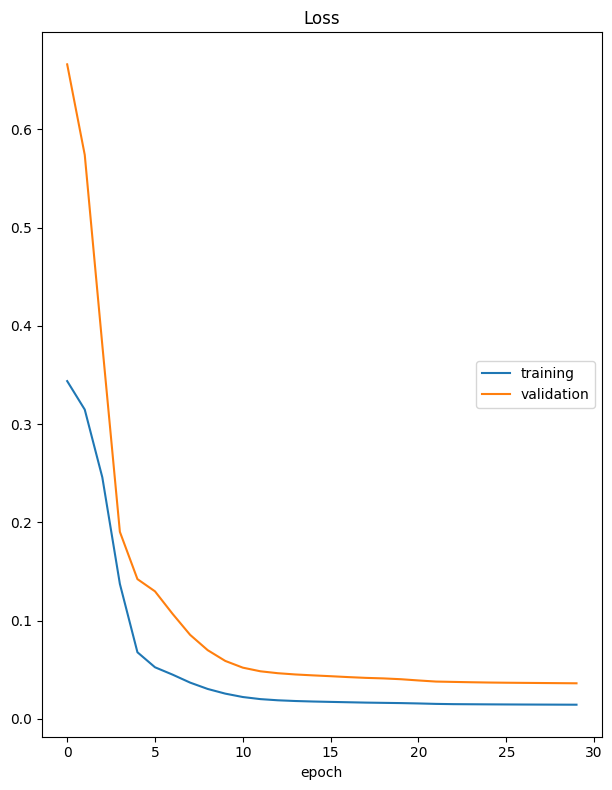

Loss
	training         	 (min:    0.015, max:    0.344, cur:    0.015)
	validation       	 (min:    0.036, max:    0.666, cur:    0.036)
Epoch [30/30], Train Loss: 0.0145, Validation Loss: 0.0363
torch.Size([16, 36, 192, 192])
(16, 36, 192, 192)
output_prob max: 0.8758100271224976
output frame max: 0.8142065405845642
torch.Size([16, 36, 192, 192])


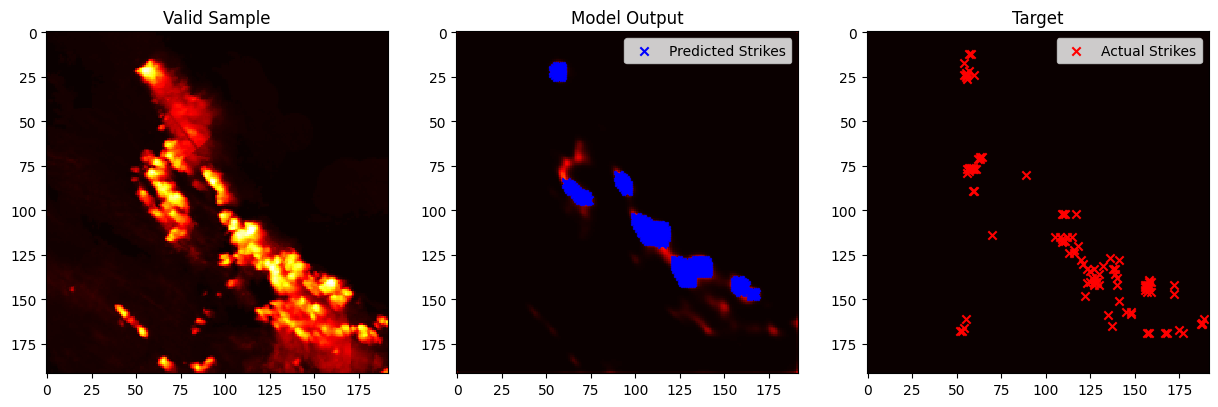

In [10]:
# instantiate
learning_rate = 0.0001
class_weight = 10.0
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
pos_weight = torch.tensor([class_weight]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
liveloss = PlotLosses()

for i, epoch in enumerate(range(epochs)):
    logs = {}
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)

    with torch.no_grad():
        # Pick the first sample from the validation set
        valid_sample, valid_target = next(iter(val_loader))
        valid_sample = valid_sample.to(device)
        valid_target = valid_target.to(device)

        # Get model output
        output_sample = model(valid_sample)

    # Update the logs dictionary
    logs['loss'] = train_loss
    logs['val_loss'] = val_loss

    # Update the plot with the current losses
    liveloss.update(logs)
    liveloss.send()

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # plot all three on subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Valid Sample (no changes)
    axs[0].imshow(valid_sample[0][0][i].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
    axs[0].set_title('Valid Sample')

    # Model Output with 'x' markers
    print(output_sample.shape)
    #output_frame = output_sample[0][i].cpu().detach().numpy()
    # get max of the strikes
    output_probs = torch.sigmoid(output_sample).cpu().detach().numpy()
    # Visualize the heatmap of probabilities
    print(output_probs.shape)
    # print output_probs with label
    print(f'output_prob max: {output_probs.max()}')
    output_frame = output_probs[0][i]
    print(f'output frame max: {output_frame.max()}')
    strike_locations_output = np.where(output_frame > 0.4)  # Adjust threshold if needed
    x_coords_output = strike_locations_output[1]
    y_coords_output = strike_locations_output[0]
    axs[1].imshow(output_frame, cmap='hot', interpolation='nearest')
    axs[1].scatter(x_coords_output, y_coords_output, marker='x', color='blue', label='Predicted Strikes')
    axs[1].set_title('Model Output')
    axs[1].legend()

    # Target with 'x' markers
    print(valid_target.shape)
    target_frame = valid_target[0][i].cpu().detach().numpy()
    strike_locations_target = np.where(target_frame > 0)  # Adjust threshold if needed
    x_coords_target = strike_locations_target[1]
    y_coords_target = strike_locations_target[0]
    axs[2].imshow(target_frame, cmap='hot', interpolation='nearest')
    axs[2].scatter(x_coords_target, y_coords_target, marker='x', color='red', label='Actual Strikes')
    axs[2].set_title('Target')
    axs[2].legend()

    plt.show()

# free memory
del logs, train_loss, val_loss, optimizer, criterion, liveloss


Here are some other models that we tried:

# Interpolation Approach
In this brief section you can see our progress towards an interpolation approach
– interpolating the images between the five minutes to get a time space
relationship by second. The idea would then be to use a ConvLSTM (if it
performed well) or a CNN with 3D layers to capture this time-space relationship.

We hoped that this would ameliorate some of the challenges that we foresaw,
namely that it would be difficult to predict both the location and the time and
the number of the strikes correctly, particularly if the time step sizes
differed between the images that we were given and the target strikes.
Unfortunately, this approach presented its own challenges, namely memory issues
as it significantly increased the amount of images that we would need to
process. Of course, had we pursued this approach, we might've been able to
make it work by significantly scaling down the size of the images and only
using one or two bands as opposed to all four, including other approaches.

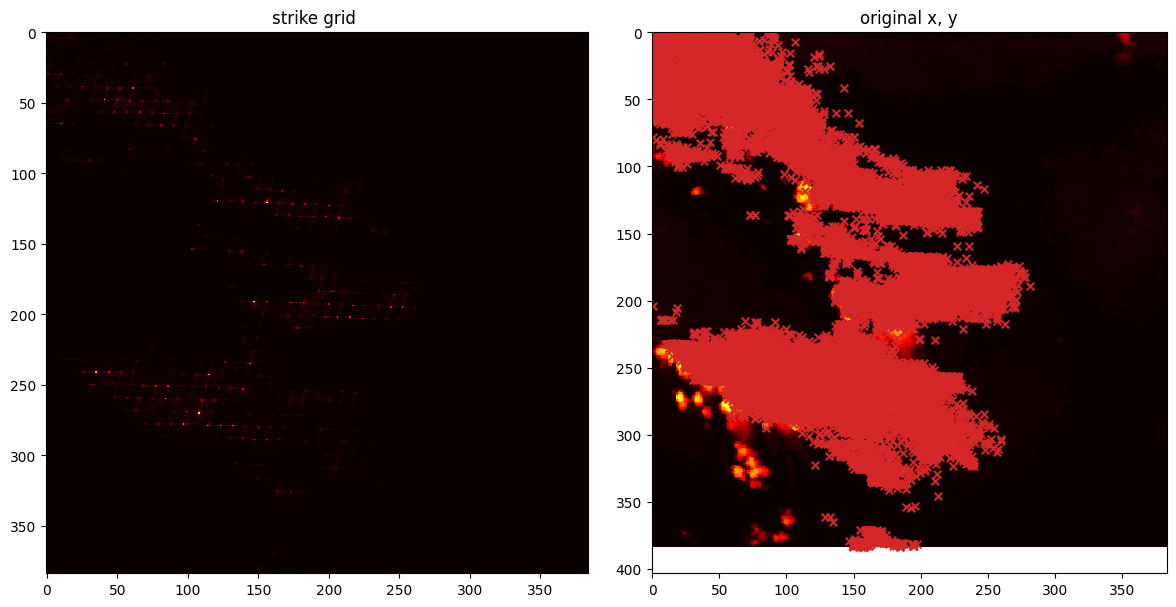

In [ ]:
# test the strike grid for the first event
event = load_event("S778114")
strike_grid = create_strike_grid(event["lght"])
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(strike_grid, cmap='hot', interpolation='nearest')
axs[0].set_title("strike grid ")

# plot the actual strike grid for the first event (i.e. column 4 in lght is pixel x and column 5 is pixel y)
# need to plot all of the pixel x and y locations with red x's in the event
axs[1].imshow(event["vil"][:,:,0], cmap='hot', interpolation='nearest')
axs[1].scatter(event["lght"][:,3], event["lght"][:,4], marker="x", s=30, c="tab:red")
axs[1].set_title("original x, y")

plt.tight_layout()
plt.show()

In [ ]:
# downscale vil and strike grids
down_size = (192, 192)
def downscale(image, new_size=down_size):
    return cv2.resize(image, new_size)

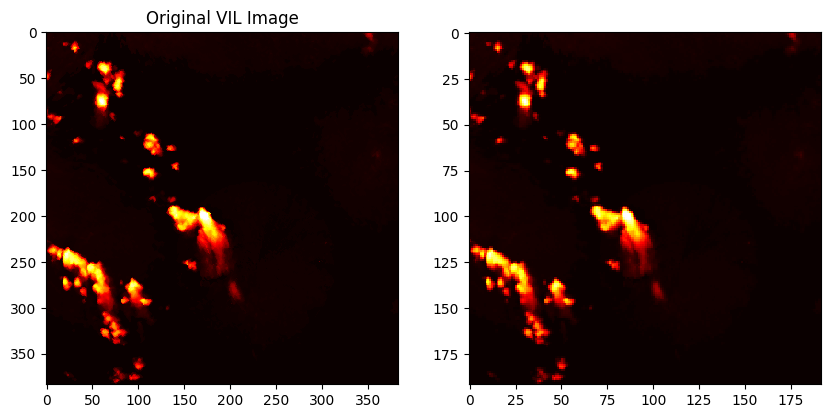

In [ ]:
# test downscale and display a downscaled image from event vil in a subplot with another
# image as the original
event = load_event("S778114")
downscaled_vil = downscale(event["vil"][:,:,0])
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(event["vil"][:,:,0], cmap='hot', interpolation='nearest')
axs[0].set_title("Original VIL Image")
axs[1].imshow(downscaled_vil, cmap='hot', interpolation='nearest')

In [ ]:
def interpolate_images(images):
    """
    Linearly interpolate between images to match the number of seconds (300 * 185).
    """
    interpolated_images = []
    for i in range(36):
        print(i)
        start_img = downscale(images[:,:, i])
        print(start_img.shape)
        if i == 35:
            end_img = start_img
        else:
          end_img = downscale(images[:,:, i + 1])
        # Linearly interpolate between start and end image for the missing 5-minute frame
        for sec in range(300):  # Interpolating for each second in the 5-minute range (300 seconds)
            alpha = sec / 300  # Linear interpolation ratio for 300 seconds
            interpolated_img = (1 - alpha) * start_img + alpha * end_img
            interpolated_images.append(interpolated_img)
    return np.array(interpolated_images)

In [ ]:
# test interpolate_images
event = load_event("S778114")
interpolated_images = interpolate_images(event["vil"][:,:,:])

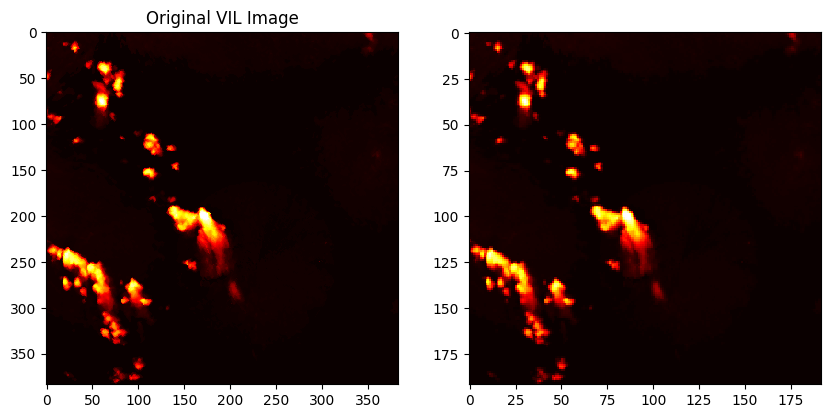

In [ ]:
# pull out the same image from the interpolated images as we pulled out in the
# downscale to compare
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(event["vil"][:,:,0], cmap='hot', interpolation='nearest')
axs[0].set_title("Original VIL Image")
axs[1].imshow(interpolated_images[0], cmap='hot', interpolation='nearest')

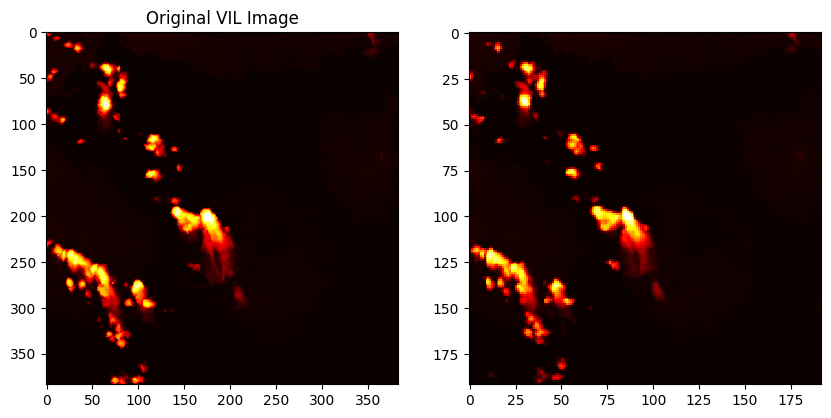

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(event["vil"][:,:,1], cmap='hot', interpolation='nearest')
axs[0].set_title("Original VIL Image")
axs[1].imshow(interpolated_images[1], cmap='hot', interpolation='nearest')

In [ ]:
def preprocess_and_save_event(event_id, image_loader, strike_loader, save_dir):
    """
    Preprocess the images and strike data for a single event, then save it as a tensor file.
    """
    # Load the images (assuming 5 types of images: 'vis', 'ir069', 'ir107', 'vil')
    images = image_loader(event_id)  # Shape: [5, 36, 224, 224]
    strike_data = strike_loader(event_id)  # Shape: [t, lat, lon, x_pixel, y_pixel] for lightning strikes

    # Preprocess the images (e.g., interpolate frames, normalize, etc.)
    processed_images = []
    for i in range(5):  # Iterate through the image types
        img_type_data = images[i]  # Shape: (36, 224, 224)
        # Interpolate each image to match the 60-second sequence per minute
        processed_image = interpolate_images(img_type_data)
        processed_images.append(processed_image)

    # Create a tensor for lightning strike data (use grid representation for strikes)
    strike_grid = create_strike_grid(strike_data, grid_size=(384, 384))  # You can adjust the grid size

    # Now save the processed data as a tensor or in HDF5 format
    save_event_data(processed_images, strike_grid, save_dir, event_id)

# Task 3 with 3 bands
In this version of our task 3 approach, we tried our model with 3 image bands:
vil and ir107. We also tried a few different approaches to try to constrain the
number of strikes that we were getting in our other models.

First, we tried a number of different loss functions, including BCE with logit
loss and then L1 and a combination of these. For the BCE loss, we tried
weighting, as you can see below, to prioritize positive identifications and
hopefully reduce false negatives. Unfortunately, we continued to have a
significant number of false positives. To combat this we tried to include a
custom loss function and a custom loss class that combined BCE, which would
output the probability of the strikes, L1, which would prioritize the
distance, and then a calculation that would penalize a significant difference
between the number of predicted strikes and the number of strikes in the target.
One such iteration of this calculation was:
np.abs(1 - number of predicted / number of output).

Unfortunately, none of these approaches gave us consistent results across
events. If we had managed our time better, and not pursued approaches that
were difficult to manage, including our first idea to interpolate the image band
values across the five minutes to get a time and space dependency per second
(which may well have worked had we managed the memory / batch training better).

In [ ]:
# packages
!pip install pycm livelossplot torchinfo -q
%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from livelossplot import PlotLosses

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from tqdm import tqdm
import random
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchinfo import summary
import torchvision
from torchvision import transforms

import h5py, IPython, PIL, os, io

# mount drive
from google.colab import drive
drive.mount('/content/drive')

# loading data

# IMPORTANT:
#   Whenever you start a new colab runtime, use the following code to download
#   the training dataset onto the runtime local storage.
#   This should take ~3-5 mins for the whole dataset.
#   You can then load data from the local storage (/content/data) into your colab
#   notebook using the `h5py` library (see example below).
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="train.h5", repo_type="dataset", local_dir="data")
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="events.csv", repo_type="dataset", local_dir="data")

# set seed and device
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

# helper functions and data investigation

# this DataFrame contains all of the event meta data
df = pd.read_csv("data/events.csv", parse_dates=["start_utc"])
#df
print(f"Total number of events: {len(df.id.unique())}")

# this function loads all of the image arrays for a given id
def load_event(id):
    "Load event"
    with h5py.File(f'data/train.h5','r') as f:
        event = {img_type: f[id][img_type][:] for img_type in ['vis', 'ir069', 'ir107', 'vil', 'lght']}
    return event

event = load_event("S778114")
for img_type in event:
    print(f"{img_type}: {event[img_type].shape} ({event[img_type].dtype})")

# these functions will plot an event

def make_gif(outfile, files, fps=10, loop=0):
    "Helper function for saving GIFs"
    imgs = [PIL.Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='gif', append_images=imgs[1:],
                 save_all=True, duration=int(1000/fps), loop=loop)
    im = IPython.display.Image(filename=outfile)
    im.reload()
    return im

def plot_event(id, output_gif=False, save_gif=False):
    "Helper function for plotting an event"
    event = load_event(id)
    t = event["lght"][:,0]# time of lightning strike (in seconds relative to first frame)
    def plot_frame(ti):
        f = (t >= ti*5*60 - 2.5*60) & (t < ti*5*60 + 2.5*60)# find which lightning strikes fall in current frame
        fig,axs = plt.subplots(1,4,figsize=(16,4))
        fig.suptitle(f"Event: {id}, Frame: {ti}, Time: {ti*5} min")
        axs[0].imshow(event["vis"][:,:,ti], vmin=0, vmax=10000, cmap="grey"), axs[0].set_title('Visible')
        axs[1].imshow(event["ir069"][:,:,ti], vmin=-8000, vmax=-1000, cmap="viridis"), axs[1].set_title('Infrared (Water Vapor)')
        axs[2].imshow(event["ir107"][:,:,ti], vmin=-7000, vmax=2000, cmap="inferno"), axs[2].set_title('Infrared (Cloud/Surface Temperature)')
        axs[3].imshow(event["vil"][:,:,ti], vmin=0, vmax=255, cmap="turbo"), axs[3].set_title('Radar (Vertically Integrated Liquid)')
        axs[3].scatter(event["lght"][f,3], event["lght"][f,4], marker="x", s=30, c="tab:red")
        axs[3].set_xlim(0,384), axs[3].set_ylim(384,0)
        if output_gif:
            file = f"_temp_{id}_{ti}.png"
            fig.savefig(file, bbox_inches="tight", dpi=150, pad_inches=0.02, facecolor="white")
            plt.close()
        else:
            plt.show()
    if output_gif:
        for ti in range(36): plot_frame(ti)
        im = make_gif(f"{id}.gif", [f"_temp_{id}_{ti}.png" for ti in range(36)])
        for ti in range(36): os.remove(f"_temp_{id}_{ti}.png")
        IPython.display.display(im)
        if not save_gif: os.remove(f"{id}.gif")
    else:
        plot_frame(0)
        plot_frame(17)
        plot_frame(34)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cuda installed! Running on GPU 0 NVIDIA A100-SXM4-40GB!
Total number of events: 800
vis: (384, 384, 36) (int16)
ir069: (192, 192, 36) (int16)
ir107: (192, 192, 36) (int16)
vil: (384, 384, 36) (uint8)
lght: (38777, 5) (float32)


In [ ]:
# image and strike data from google drive

# # load and test npy downsized vis
# vis_data = np.load('/content/drive/MyDrive/fay-downsized-imgs/downsized_vis.npy')
# print(vis_data.shape)

# # load and test npy downsized ir069
# ir069_data = np.load('/content/drive/MyDrive/fay-downsized-imgs/downsized_ir069.npy')
# print(ir069_data.shape)

# load and test npy downsized ir107
ir107_data = np.load('/content/drive/MyDrive/fay-downsized-imgs/downsized_ir107.npy')
print(ir107_data.shape)

# load and test npy downsized vil
vil_data = np.load('/content/drive/MyDrive/fay-downsized-imgs/downsized_vil.npy')
print(vil_data.shape)

# load and test npy strike arrays
strike_data = np.load('/content/drive/MyDrive/fay-downsized-imgs/strike_array.npy')
print(strike_data.shape)

(800, 36, 192, 192)
(800, 36, 192, 192)
(800, 36, 192, 192)


In [ ]:
# dataset and dataloader
batch_size = 16
epochs = 30
num_events = 400

class LightningStrikeDataset(Dataset):
    def __init__(self, vil, ir107, strike_data, transform=None):
        self.vil = vil
        self.ir107 = ir107
        self.strike_data = strike_data
        self.transform = transform

    def __len__(self):
        return len(self.vil)

    def __getitem__(self, idx):
        ir107 = self.ir107[idx]
        ir107 = torch.tensor(ir107, dtype=torch.float32)
        ir107 = ir107.unsqueeze(0)

        vil = self.vil[idx]
        vil = torch.tensor(vil, dtype=torch.float32)
        vil = vil.unsqueeze(0)

        images = torch.cat((ir107, vil), dim=0)

        strikes = self.strike_data[idx]
        strikes = torch.tensor(strikes, dtype=torch.float32)

        if self.transform:
            images = self.transform(images)
            strikes = self.transform(strikes)

        return images, strikes

train_idx, test_val_idx = train_test_split(range(num_events), test_size=0.2, shuffle=False)
val_idx, test_idx = train_test_split(test_val_idx, test_size=0.2, shuffle=False)

train_dataset = LightningStrikeDataset(vil_data[train_idx], ir107_data[train_idx], strike_data[train_idx])
val_dataset = LightningStrikeDataset(vil_data[val_idx], ir107_data[val_idx], strike_data[val_idx])
test_dataset = LightningStrikeDataset(vil_data[test_idx], ir107_data[test_idx], strike_data[test_idx])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# model
class SimpleLightningStrikeCNN3D(nn.Module):
    def __init__(self):
        super(SimpleLightningStrikeCNN3D, self).__init__()
        self.conv1 = nn.Conv3d(2, 16, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4 = nn.Conv3d(64, 1, kernel_size=(3, 3, 3), padding=(1, 1, 1))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = x.view(x.size(0), 36, 192, 192)
        return x

model = SimpleLightningStrikeCNN3D().to(device)
summary(model, input_size=(2, 36, 192, 192), batch_dim=0)


Layer (type:depth-idx)                   Output Shape              Param #
SimpleLightningStrikeCNN3D               [1, 36, 192, 192]         --
├─Conv3d: 1-1                            [1, 16, 36, 192, 192]     880
├─Conv3d: 1-2                            [1, 32, 36, 192, 192]     13,856
├─Conv3d: 1-3                            [1, 64, 36, 192, 192]     55,360
├─Conv3d: 1-4                            [1, 1, 36, 192, 192]      1,729
Total params: 71,825
Trainable params: 71,825
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 95.32
Input size (MB): 10.62
Forward/backward pass size (MB): 1199.70
Params size (MB): 0.29
Estimated Total Size (MB): 1210.61

In [ ]:
# train model
def train(model, train_loader, optimizer, criterion, accumulation_steps=2): # Added accumulation_steps
    model.train()
    train_loss = 0.0
    optimizer.zero_grad() # Zero grad before the loop

    for i, (images, strikes) in enumerate(train_loader):
        images, strikes = images.to(device), strikes.to(device)
        outputs = model(images)
        loss = criterion(outputs, strikes)
        loss = loss / accumulation_steps # Scale loss
        loss.backward()

        if (i + 1) % accumulation_steps == 0:  # Update every accumulation_steps
            optimizer.step()  # Update model parameters using the accumulated gradients
            optimizer.zero_grad()  # Zero gradients for the next accumulation cycle

        train_loss += loss.item()
    train_loss /= len(train_loader)
    return train_loss

# validate
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():

        for images, strikes in val_loader:
            images, strikes = images.to(device), strikes.to(device)
            outputs = model(images)
            loss = criterion(outputs, strikes)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    return val_loss

In [ ]:
# import torch
# import torch.nn as nn

# class CombinedLoss(nn.Module):
#     def __init__(self, weight_prob=1.0, weight_dist=1.0, weight_count=0.3, strike_threshold=0.5):
#         super(CombinedLoss, self).__init__()
#         self.weight_prob = weight_prob
#         self.weight_dist = weight_dist
#         self.weight_count = weight_count  # Weight for the strike count penalty
#         self.strike_threshold = strike_threshold
#         self.criterion_prob = nn.BCEWithLogitsLoss()
#         self.criterion_dist = nn.L1Loss()

#     def forward(self, outputs, targets):
#         # Probability loss
#         loss_prob = self.criterion_prob(outputs, targets)

#         # Distance loss (calculated only for predicted strikes)
#         outputs_probs = torch.sigmoid(outputs)  # Get probabilities from logits
#         predicted_strikes = outputs_probs > self.strike_threshold
#         target_strikes = targets > 0  # Assuming targets are 0 or 1

#         # Calculate distance loss only for predicted and actual strike locations
#         distance_loss = self.criterion_dist(
#             outputs[predicted_strikes & target_strikes],
#             targets[predicted_strikes & target_strikes]
#         )

#         # Strike count penalty (counting distinct locations)
#         predicted_strikes = outputs > self.strike_threshold  # Boolean tensor of predicted strikes
#         target_strikes = targets > 0  # Boolean tensor of target strikes

#         # Get indices of strike locations
#         predicted_indices = torch.nonzero(predicted_strikes)
#         target_indices = torch.nonzero(target_strikes)

#         predicted_count = len(torch.unique(predicted_indices, dim=0))
#         actual_count = len(torch.unique(target_indices, dim=0))

#         # Convert to tensors
#         predicted_count = torch.tensor(predicted_count, device=outputs.device, dtype=torch.float32) # Convert to tensor on the same device
#         actual_count = torch.tensor(actual_count, device=outputs.device, dtype=torch.float32)   # Convert to tensor on the same device

#         count_diff = torch.abs(predicted_count - actual_count)  # Discrepancy

#         # Total loss with strike count penalty
#         total_loss = (
#             self.weight_prob * loss_prob
#             + self.weight_dist * distance_loss
#             + self.weight_count * count_diff  # Add the penalty
#         )

#         return total_loss

In [ ]:
def mask_output(output_frame, boundary_width=5):
  """Masks the output to ignore predictions near the boundary.

  Args:
    output_frame: The model's output prediction (numpy array).
    boundary_width: The width of the boundary to be masked (in pixels).

  Returns:
    masked_output: The output frame with the boundary masked out.
  """

  mask = np.ones_like(output_frame)  # Initialize mask with all ones
  mask[:boundary_width, :] = 0  # Mask top boundary
  mask[-boundary_width:, :] = 0  # Mask bottom boundary
  mask[:, :boundary_width] = 0  # Mask left boundary
  mask[:, -boundary_width:] = 0  # Mask right boundary

  masked_output = output_frame * mask  # Apply the mask
  return masked_output

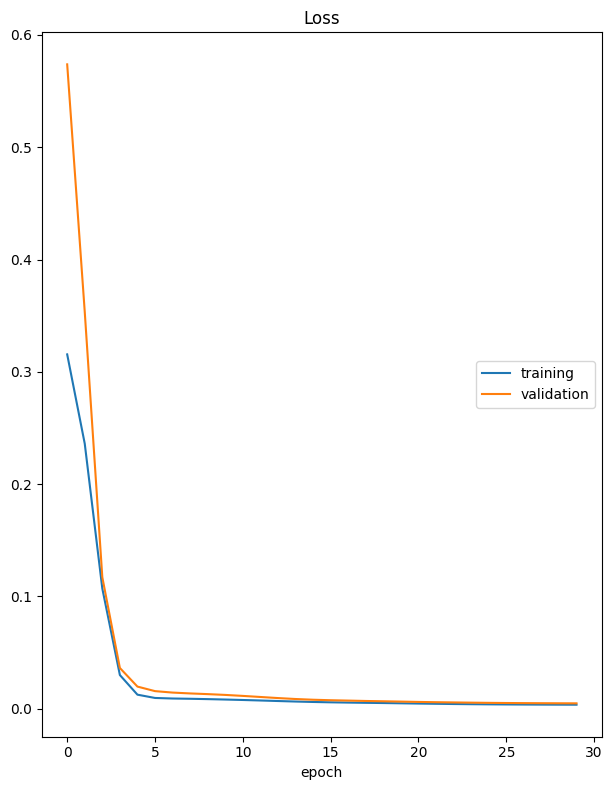

Loss
	training         	 (min:    0.003, max:    0.316, cur:    0.003)
	validation       	 (min:    0.005, max:    0.574, cur:    0.005)

Epoch 30/30, Train Loss: 0.0035, Val Loss: 0.0047
output frame shape: (192, 192)
output min: 0.0
output max: 0.7760130167007446

output num strikes: 6109
target num strikes: 9427

target distinct locations of strikes: 94


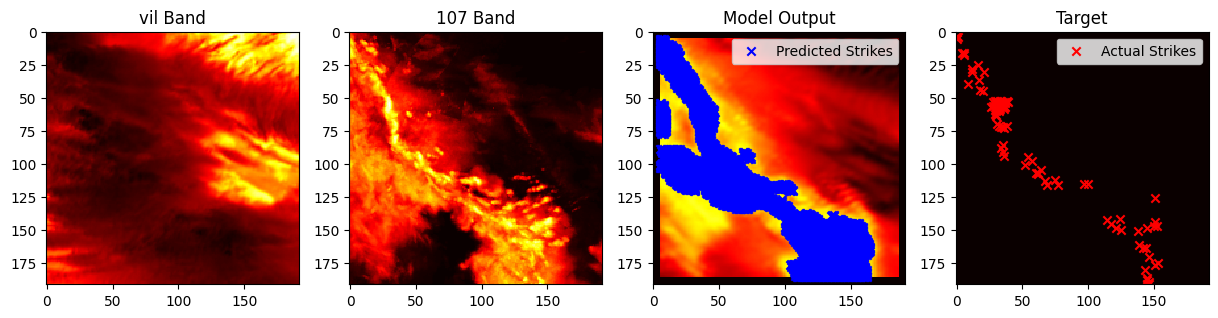

In [ ]:
# instantiate and plot results
learning_rate = 0.0001
class_weight = 20.0
strike_threshold = 0.8
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# pos_weight = torch.tensor([class_weight]).to(device)
neg_weight = torch.tensor([1.0]).to(device)

# focal loss and

#criterion = CombinedLoss(weight_prob=1.0, weight_dist=1.0, weight_count=0.1)  # Adjust weights as needed
criterion = nn.BCEWithLogitsLoss(pos_weight=neg_weight)
# criterion = nn.L1Loss()
liveloss = PlotLosses()

for i, epoch in enumerate(range(epochs)):
    logs = {}
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)

    with torch.no_grad():
        # Pick the first sample from the validation set
        valid_sample, valid_target = next(iter(val_loader))
        valid_sample = valid_sample.to(device)
        valid_target = valid_target.to(device)

        # Get model output
        output_sample = model(valid_sample)

    # Update the logs dictionary
    logs['loss'] = train_loss
    logs['val_loss'] = val_loss

    # Update the plot with the current losses
    liveloss.update(logs)
    liveloss.send()

    print(f'\nEpoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    output_frame = output_sample[0][0].cpu().detach().numpy()
    # normalize output_frame values
    output_frame = (output_frame - np.min(output_frame)) / (np.max(output_frame) - np.min(output_frame))
    output_frame = mask_output(output_frame)
    # print output frame shape
    print(f'output frame shape: {output_frame.shape}')
    strike_locations_output = np.where(output_frame > 0.8 * np.max(output_frame))  # Adjust threshold if needed

    # print the output min max
    print(f'output min: {np.min(output_frame)}')
    print(f'output max: {np.max(output_frame)}\n')

    # print num strikes in target and sample, sum the instances where sample greater than threshold not total
    print(f'output num strikes: {np.sum(output_frame > 0.8 * np.max(output_frame))}')
    print(f'target num strikes: {torch.sum(valid_target > 0)}\n')

    # print the number of distinct locations/pixels in which there is a strike for the target
    target_frame = valid_target[0][0].cpu().detach().numpy()
    strike_locations_target = np.where(target_frame > 0)  # Adjust threshold if needed
    print(f'target distinct locations of strikes: {len(np.unique(strike_locations_target))}')


    # plot all three on subplots
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    # plot the image band
    axs[0].imshow(valid_sample[0][0][0].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
    axs[0].set_title('vil Band')
    # plot the image band
    axs[1].imshow(valid_sample[0][1][0].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
    axs[1].set_title('107 Band')

    # Model Output with 'x' markers
    x_coords_output = strike_locations_output[1]
    y_coords_output = strike_locations_output[0]
    axs[2].imshow(output_frame, cmap='hot', interpolation='nearest')
    axs[2].scatter(x_coords_output, y_coords_output, marker='x', color='blue', label='Predicted Strikes')
    axs[2].set_title('Model Output')
    axs[2].legend()

    # Target with 'x' markers
    target_frame = valid_target[0][0].cpu().detach().numpy()
    strike_locations_target = np.where(target_frame > 0)  # Adjust threshold if needed
    x_coords_target = strike_locations_target[1]
    y_coords_target = strike_locations_target[0]
    axs[3].imshow(target_frame, cmap='hot', interpolation='nearest')
    axs[3].scatter(x_coords_target, y_coords_target, marker='x', color='red', label='Actual Strikes')
    axs[3].set_title('Target')
    axs[3].legend()

    plt.show()

# free memory
del logs, train_loss, val_loss, optimizer, criterion, liveloss


# Task 3 with all 4 bands
In this version of our task 3 approach, we tried our model with all 4 image bands.
We used 4 convolutional layers, 30 epochs, a batch size of 16, and trained
on 300 events, less than the 400 that we used for other versions given
memory considerations and training speed. We often ran out of RAM while running
this version and while our results are promising, they were not significantly
better than the results we had seen with our one band model, and the loss function
plots displayed overfitting. While we tried to remedy this by including dropout,
adjusting the batch size and learning rate, we were unfortunately not able to maintain our
results and reduce overfitting.

Thus, we have included here the simplest model that produced the best results
when using four bands. The main challenge that we faced when tuning this version
and generally for task 3 was managing the threshold at which to plot/indicate
lightning strikes. We tested dynamic (adjusting based on the max of the frame)
and fixed (anywhere from 0.4 to 0.9 given the normalization of our grids)
strike thresholds, but, unfortunately, we were not always able to achieve
replicable results across the events. Our strike grids seemed to work well
and the heat maps that we produced for our outputs, based on the events seemed
to predict very well the likely location of the strikes, but it was difficult to
then translate this into success identifying actual strikes.

A challenge that went hand in hand with the above, was predicting the number
of strikes that might strike during a given event. We worked on our model and
loss function extensively to try and remedy this, and we even decided to try
models that would predict only the number of strikes per event, given the images.
The idea with this approach would have been to combine the models either through
post-training processing (processing the results) and combining into a dataframe
or by combining the models themselves, either to produce multiple outputs or to
use the infrastructure from one to inform the other.

In [ ]:
# packages
!pip install pycm livelossplot torchinfo -q
%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from livelossplot import PlotLosses

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from tqdm import tqdm
import random
import cv2
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchinfo import summary
import torchvision
from torchvision import transforms

import h5py, IPython, PIL, os, io

# mount drive
from google.colab import drive
drive.mount('/content/drive')

# loading data

# IMPORTANT:
#   Whenever you start a new colab runtime, use the following code to download
#   the training dataset onto the runtime local storage.
#   This should take ~3-5 mins for the whole dataset.
#   You can then load data from the local storage (/content/data) into your colab
#   notebook using the `h5py` library (see example below).
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="train.h5", repo_type="dataset", local_dir="data")
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="events.csv", repo_type="dataset", local_dir="data")

# set seed and device
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

# helper functions and data investigation

# this DataFrame contains all of the event meta data
df = pd.read_csv("data/events.csv", parse_dates=["start_utc"])
#df
print(f"Total number of events: {len(df.id.unique())}")

# this function loads all of the image arrays for a given id
def load_event(id):
    "Load event"
    with h5py.File(f'data/train.h5','r') as f:
        event = {img_type: f[id][img_type][:] for img_type in ['vis', 'ir069', 'ir107', 'vil', 'lght']}
    return event

event = load_event("S778114")
for img_type in event:
    print(f"{img_type}: {event[img_type].shape} ({event[img_type].dtype})")

# these functions will plot an event

def make_gif(outfile, files, fps=10, loop=0):
    "Helper function for saving GIFs"
    imgs = [PIL.Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='gif', append_images=imgs[1:],
                 save_all=True, duration=int(1000/fps), loop=loop)
    im = IPython.display.Image(filename=outfile)
    im.reload()
    return im

def plot_event(id, output_gif=False, save_gif=False):
    "Helper function for plotting an event"
    event = load_event(id)
    t = event["lght"][:,0]# time of lightning strike (in seconds relative to first frame)
    def plot_frame(ti):
        f = (t >= ti*5*60 - 2.5*60) & (t < ti*5*60 + 2.5*60)# find which lightning strikes fall in current frame
        fig,axs = plt.subplots(1,4,figsize=(16,4))
        fig.suptitle(f"Event: {id}, Frame: {ti}, Time: {ti*5} min")
        axs[0].imshow(event["vis"][:,:,ti], vmin=0, vmax=10000, cmap="grey"), axs[0].set_title('Visible')
        axs[1].imshow(event["ir069"][:,:,ti], vmin=-8000, vmax=-1000, cmap="viridis"), axs[1].set_title('Infrared (Water Vapor)')
        axs[2].imshow(event["ir107"][:,:,ti], vmin=-7000, vmax=2000, cmap="inferno"), axs[2].set_title('Infrared (Cloud/Surface Temperature)')
        axs[3].imshow(event["vil"][:,:,ti], vmin=0, vmax=255, cmap="turbo"), axs[3].set_title('Radar (Vertically Integrated Liquid)')
        axs[3].scatter(event["lght"][f,3], event["lght"][f,4], marker="x", s=30, c="tab:red")
        axs[3].set_xlim(0,384), axs[3].set_ylim(384,0)
        if output_gif:
            file = f"_temp_{id}_{ti}.png"
            fig.savefig(file, bbox_inches="tight", dpi=150, pad_inches=0.02, facecolor="white")
            plt.close()
        else:
            plt.show()
    if output_gif:
        for ti in range(36): plot_frame(ti)
        im = make_gif(f"{id}.gif", [f"_temp_{id}_{ti}.png" for ti in range(36)])
        for ti in range(36): os.remove(f"_temp_{id}_{ti}.png")
        IPython.display.display(im)
        if not save_gif: os.remove(f"{id}.gif")
    else:
        plot_frame(0)
        plot_frame(17)
        plot_frame(34)

Populating the interactive namespace from numpy and matplotlib
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Cuda installed! Running on GPU 0 NVIDIA A100-SXM4-40GB!
Total number of events: 800
vis: (384, 384, 36) (int16)
ir069: (192, 192, 36) (int16)
ir107: (192, 192, 36) (int16)
vil: (384, 384, 36) (uint8)
lght: (38777, 5) (float32)


In [ ]:
# # load and test npy downsized vis
vis_data = np.load('/content/drive/MyDrive/fay-downsized-imgs/downsized_vis.npy')
print(vis_data.shape)

# load and test npy downsized ir069
ir069_data = np.load('/content/drive/MyDrive/fay-downsized-imgs/downsized_ir069.npy')
print(ir069_data.shape)

# load and test npy downsized ir107
ir107_data = np.load('/content/drive/MyDrive/fay-downsized-imgs/downsized_ir107.npy')
print(ir107_data.shape)

# load and test npy downsized vil
vil_data = np.load('/content/drive/MyDrive/fay-downsized-imgs/downsized_vil.npy')
print(vil_data.shape)

# load and test npy strike arrays
strike_data = np.load('/content/drive/MyDrive/fay-downsized-imgs/strike_array.npy')
print(strike_data.shape)

(800, 36, 192, 192)
(800, 36, 192, 192)
(800, 36, 192, 192)
(800, 36, 192, 192)
(800, 36, 192, 192)


In [ ]:
# Define the dataset class
batch_size = 16
epochs = 30
num_events = 300

class LightningStrikeDataset(Dataset):
    def __init__(self, vis_data, ir069_data, ir107_data, vil_data, strike_data, transform=None):
        self.vis_data = vis_data # Shape: (800, 36, 192, 192)
        self.ir069_data = ir069_data  # Shape: (800, 36, 192, 192)
        self.ir107_data = ir107_data  # Shape: (800, 36, 192, 192)
        self.vil_data = vil_data  # Shape: (800, 36, 192, 192)
        self.strike_data = strike_data  # Shape: (800, 36, 192, 192)
        self.transform = transform

    def __len__(self):
        return len(self.vil_data)  # 800 events

    def __getitem__(self, idx):
        vis_images = self.vis_data[idx]  # Shape: (36, 192, 192)
        vis_images = torch.tensor(vis_images, dtype=torch.float32)

        ir069_images = self.ir069_data[idx]  # Shape: (36, 192, 192)
        ir069_images = torch.tensor(ir069_images, dtype=torch.float32)

        ir107_images = self.ir107_data[idx]  # Shape: (36, 192, 192)
        ir107_images = torch.tensor(ir107_images, dtype=torch.float32)

        vil_images = self.vil_data[idx]  # Shape: (36, 192, 192)
        vil_images = torch.tensor(vil_images, dtype=torch.float32)

        images = torch.cat([vis_images.unsqueeze(0),
                            ir069_images.unsqueeze(0),
                            ir107_images.unsqueeze(0),
                            vil_images.unsqueeze(0)], dim=0)

        strikes = self.strike_data[idx]  # Shape: (36, 192, 192)
        strikes = torch.tensor(strikes, dtype=torch.float32)

        if self.transform:
            images = self.transform(images)
            strikes = self.transform(strikes)

        return images, strikes

# Split data into train/val/test (80/10/10 split)
train_idx, test_val_idx = train_test_split(range(num_events), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(test_val_idx, test_size=0.2, random_state=42)

# Create datasets for each split
train_dataset = LightningStrikeDataset(vis_data=vis_data, ir069_data=ir069_data,
                                       ir107_data=ir107_data, vil_data=vil_data,
                                       strike_data=strike_data)
val_dataset = LightningStrikeDataset(vis_data=vis_data, ir069_data=ir069_data,
                                     ir107_data=ir107_data, vil_data=vil_data,
                                     strike_data=strike_data)
test_dataset = LightningStrikeDataset(vis_data=vis_data, ir069_data=ir069_data,
                                      ir107_data=ir107_data, vil_data=vil_data,
                                      strike_data=strike_data)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# model
class SimpleLightningStrikeCNN3D(nn.Module):
    def __init__(self):
        super(SimpleLightningStrikeCNN3D, self).__init__()
        # Modify input channels to 1 (since we're testing with a single band)
        self.conv1 = nn.Conv3d(4, 16, kernel_size=(3, 3, 3), padding=(1, 1, 1))  # (input_channels, output_channels, kernel_size)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4 = nn.Conv3d(64, 1, kernel_size=(3, 3, 3), padding=(1, 1, 1)) # Output 1 channel

    def forward(self, x):
        # Forward pass through the convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = x.view(x.size(0), 36, 192, 192)

        return x

# Instantiate the model and send to device if room
model = SimpleLightningStrikeCNN3D().to(device)
summary(model, input_size=(4, 36, 192, 192), batch_dim=0)


Layer (type:depth-idx)                   Output Shape              Param #
SimpleLightningStrikeCNN3D               [1, 36, 192, 192]         --
├─Conv3d: 1-1                            [1, 16, 36, 192, 192]     1,744
├─Conv3d: 1-2                            [1, 32, 36, 192, 192]     13,856
├─Conv3d: 1-3                            [1, 64, 36, 192, 192]     55,360
├─Conv3d: 1-4                            [1, 1, 36, 192, 192]      1,729
Total params: 72,689
Trainable params: 72,689
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 96.47
Input size (MB): 21.23
Forward/backward pass size (MB): 1199.70
Params size (MB): 0.29
Estimated Total Size (MB): 1221.23

In [ ]:
# # custom loss penalizing diff btwn num target strikes and num predicted strikes
# def custom_loss(outputs, targets, weight=0.1):  # Adjust 'weight' as needed
#        bce_loss = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)(outputs, targets)
#        pred_count = torch.sum(torch.sigmoid(outputs) > strike_threshold)
#        target_count = torch.sum(targets > 0)
#        poisson_loss = weight * torch.nn.functional.poisson_nll_loss(pred_count, target_count, log_input=False)
#        total_loss = bce_loss + poisson_loss
#        return total_loss

# train model
def train(model, train_loader, optimizer, criterion, accumulation_steps=2): # Added accumulation_steps
    model.train()
    train_loss = 0.0
    optimizer.zero_grad() # Zero grad before the loop

    for i, (images, strikes) in enumerate(train_loader):
        images, strikes = images.to(device), strikes.to(device)
        outputs = model(images)
        loss = criterion(outputs, strikes)
        loss = loss / accumulation_steps # Scale loss
        loss.backward()

        if (i + 1) % accumulation_steps == 0:  # Update every accumulation_steps
            optimizer.step()  # Update model parameters using the accumulated gradients
            optimizer.zero_grad()  # Zero gradients for the next accumulation cycle

        train_loss += loss.item()
    train_loss /= len(train_loader)
    return train_loss

# validate
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():

        for images, strikes in val_loader:
            images, strikes = images.to(device), strikes.to(device)
            outputs = model(images)
            loss = criterion(outputs, strikes)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    return val_loss

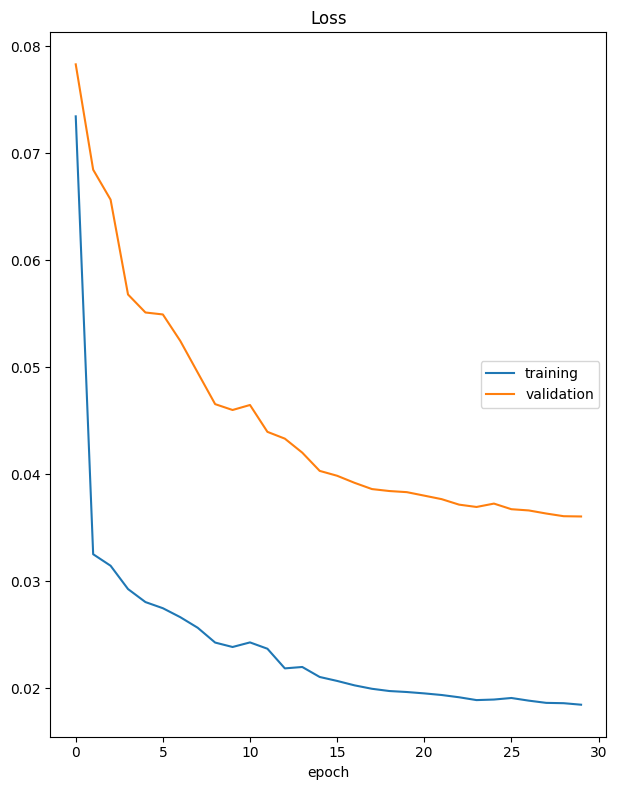

Loss
	training         	 (min:    0.018, max:    0.073, cur:    0.018)
	validation       	 (min:    0.036, max:    0.078, cur:    0.036)

Epoch [30/30], Train Loss: 0.0185, Validation Loss: 0.0360
valid sample shape: torch.Size([16, 4, 36, 192, 192]), valid sample[0] shape: torch.Size([4, 36, 192, 192])
output prob max: 0.6600000262260437, output frame max: 0.38999998569488525



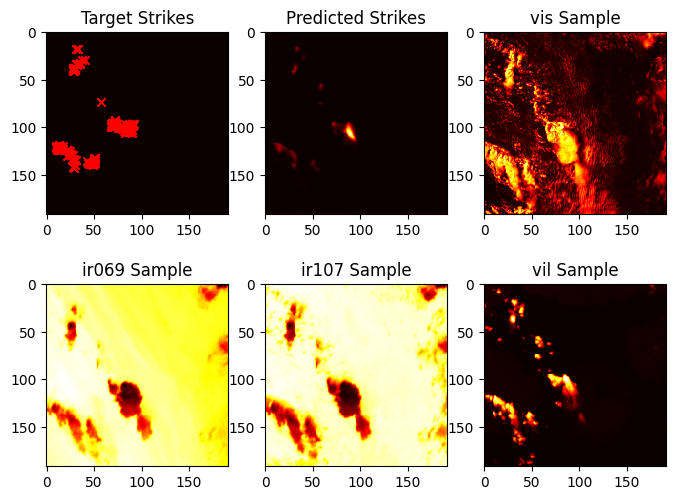

In [ ]:
# instantiate
learning_rate = 0.001
class_weight = 10.0 # weight
strike_threshold = 0.4 # strike threshold
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
pos_weight = torch.tensor([class_weight]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
liveloss = PlotLosses()

for i, epoch in enumerate(range(epochs)):
    logs = {}
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)

    with torch.no_grad():
        # Pick the first sample from the validation set
        valid_sample, valid_target = next(iter(val_loader))
        valid_sample = valid_sample.to(device)
        valid_target = valid_target.to(device)

        # Get model output
        output_sample = model(valid_sample)

    import math
    batch_sample_num = math.floor(i*batch_size/epochs)

    # Update the logs dictionary
    logs['loss'] = train_loss
    logs['val_loss'] = val_loss

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss,
    }, '/content/drive/MyDrive/fay-model-CNN3D/cnn3d_model.pth')

    # Update the plot with the current losses
    liveloss.update(logs)
    liveloss.send()

    print(f'\nEpoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    # print valid sample shape with label
    print(f'valid sample shape: {valid_sample.shape}, valid sample[0] shape: {valid_sample[0].shape}')

    # plot all three on subplots
    fig, axs = plt.subplots(2, 3, figsize=(8, 6))

    # vis Sample (no changes)
    axs[0, 2].imshow(valid_sample[0][0][0].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
    axs[0, 2].set_title('vis Sample')

    # ir069 Sample (no changes)
    axs[1, 0].imshow(valid_sample[0][1][0].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
    axs[1, 0].set_title('ir069 Sample')

    # ir107 Sample (no changes)
    axs[1, 1].imshow(valid_sample[0][2][0].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
    axs[1, 1].set_title('ir107 Sample')

    # Vil Sample (no changes)
    axs[1, 2].imshow(valid_sample[0][3][0].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
    axs[1, 2].set_title('vil Sample')

    # output with 'x' markers
    output_probs = torch.sigmoid(output_sample).cpu().detach().numpy()
    output_frame = output_probs[0][0]
    print(f'output prob max: {round(output_probs.max(), 2)}, output frame max: {round(output_frame.max(), 2)}\n')
    strike_locations_output = np.where(output_frame > strike_threshold) # threshold
    x_coords_output = strike_locations_output[1]
    y_coords_output = strike_locations_output[0]

    axs[0, 1].imshow(output_frame, cmap='hot', interpolation='nearest')
    axs[0, 1].scatter(x_coords_output, y_coords_output, marker='x', color='blue')
    axs[0, 1].set_title('Predicted Strikes')

    # target with 'x' markers
    target_frame = valid_target[0][0].cpu().detach().numpy()
    strike_locations_target = np.where(target_frame > 0)  # Adjust threshold if needed
    x_coords_target = strike_locations_target[1]
    y_coords_target = strike_locations_target[0]

    axs[0, 0].imshow(target_frame, cmap='hot', interpolation='nearest')
    axs[0, 0].scatter(x_coords_target, y_coords_target, marker='x', color='red')
    axs[0, 0].set_title('Target Strikes')

    plt.show()

# free memory
del logs, train_loss, val_loss, optimizer, criterion, liveloss


## Temporal prediction:

The goal here is to explore the any patterns of the ligtning over time - the following are the EDA carried out for this part:

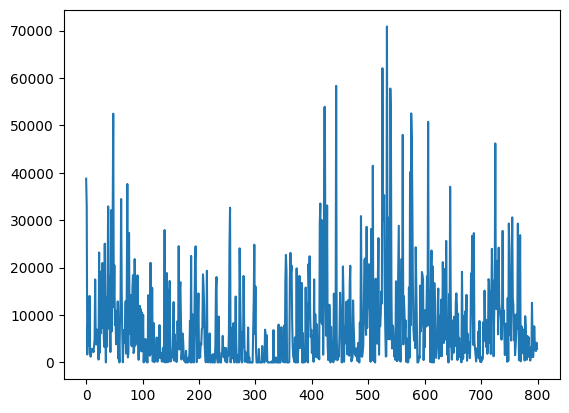

In [12]:
id = id_list[0]
light_list = []
for id in id_list:
  event = load_event(id)
  num_light = event["lght"].shape[0]
  light_list.append(num_light)
plt.plot(light_list)
plt.show()

In [13]:
print('The most number of lightning: ',max(light_list), "id: ", id_list[light_list.index(max(light_list))])
print('The least number of lightning:', min(light_list),
      "id:", id_list[light_list.index(min(light_list))])
print("Mean: ", np.mean(light_list))
print("Median: ", np.median(light_list))

The most number of lightning:  70885 id:  S823291
The least number of lightning: 0 id: S784255
Mean:  8127.255
Median:  4577.0


In [17]:
df_lightning = pd.DataFrame({
    'ID': id_list,          # Use 'ID' as the column name for id_list
    'Lightning_Count': light_list  # Use 'Lightning_Count' as the column name for light_list
})

# Display the initial DataFrame
print(df_lightning)

# Initialize a list to store frame-wise lightning counts for each ID
frame_lightning_counts = []

#temp = id_list[0:10]  # Process a subset of IDs for testing

# Loop through each ID in temp
# Loop through each ID in id_list
for event_id in id_list:
    # Load the event data
    test = load_event(event_id)

    # Get the time of lightning strikes
    t = test["lght"][:, 0]

    # List to store frame-wise lightning counts for the current event
    lightning_counts_per_frame = []
    lightning_counts_per_frame_pct = []

    # Fixed interval length: 5 minutes (300 seconds)
    frame_duration = 5 * 60  # 5 minutes in seconds

    # Loop through 36 frames (3 hours = 36 intervals of 5 minutes each)
    for ti in range(36):
        # Calculate the start and end time for the current frame
        frame_start = ti * frame_duration
        frame_end = (ti + 1) * frame_duration

        # Find the lightning strikes that fall into the current frame
        f = (t >= frame_start) & (t < frame_end)
        count = f.sum()  # Count the number of lightning strikes in the current frame

        # Append the count for this frame
        lightning_counts_per_frame.append(count)
    # Append the frame-wise lightning counts to the list
    frame_lightning_counts.append(lightning_counts_per_frame)

# Add the frame-wise counts as a new column in df_lightning
df_lightning['Frame_Lightning_Counts'] = pd.Series(frame_lightning_counts, index=range(len(id_list)))

# Validation Check
for i, row in df_lightning.iterrows():
    total_per_frame = sum(row['Frame_Lightning_Counts'])
    total_count = row['Lightning_Count']
    if total_per_frame != total_count:
        print(f"WARNING: Mismatch for ID {row['ID']}! Total: {total_count}, Sum of Frames: {total_per_frame}")

# Display the resulting DataFrame
df_lightning


          ID  Lightning_Count
0    S778114            38777
1    S767475            33131
2    S771210             1691
3    S782022             7968
4    S769788             7695
..       ...              ...
795  S842315             4108
796  S843992             2772
797  S831751             2400
798  S843692             4189
799  S832818             2876

[800 rows x 2 columns]


,ID,Lightning_Count,Frame_Lightning_Counts
0,S778114,38777,"[608, 1200, 788, 743, 738, 730, 716, 843, 852,..."
1,S767475,33131,"[719, 767, 817, 893, 959, 1026, 980, 986, 915,..."
2,S771210,1691,"[35, 30, 35, 35, 39, 41, 56, 49, 63, 73, 63, 6..."
3,S782022,7968,"[312, 278, 305, 305, 370, 441, 415, 402, 330, ..."
4,S769788,7695,"[69, 77, 92, 103, 92, 108, 126, 108, 136, 130,..."
...,...,...,...
795,S842315,4108,"[71, 103, 139, 142, 102, 97, 107, 121, 83, 81,..."
796,S843992,2772,"[104, 124, 131, 127, 134, 105, 108, 150, 120, ..."
797,S831751,2400,"[51, 71, 41, 36, 75, 89, 143, 156, 160, 137, 9..."
798,S843692,4189,"[31, 63, 49, 42, 32, 36, 56, 46, 46, 35, 53, 6..."


### Investigating any long term trends

Since each storm lasts for 3 hours, we can frist explore if there are any variations in lightning frequency over the 3 hours. First, removing any storms that do not haev any lightning.

In [19]:
df_filtered = df_lightning[df_lightning['Lightning_Count'] != 0]

In [20]:
# Function to calculate frame-wise percentages
def calculate_percentage(frame_counts):
    total = sum(frame_counts)
    if total == 0:
        return [0] * len(frame_counts)  # Avoid division by zero
    return [(count / total) * 100 for count in frame_counts]

# Compute the percentage list for each row
df_filtered['Frame_Lightning_Percentage'] = df_filtered['Frame_Lightning_Counts'].apply(calculate_percentage)
# Display the updated DataFrame
df_filtered


<ipython-input-20-ec6ff1190a16>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Frame_Lightning_Percentage'] = df_filtered['Frame_Lightning_Counts'].apply(calculate_percentage)


,ID,Lightning_Count,Frame_Lightning_Counts,Frame_Lightning_Percentage
0,S778114,38777,"[608, 1200, 788, 743, 738, 730, 716, 843, 852,...","[1.5679397581040306, 3.0946179436263765, 2.032..."
1,S767475,33131,"[719, 767, 817, 893, 959, 1026, 980, 986, 915,...","[2.170172949805318, 2.315052367872989, 2.46596..."
2,S771210,1691,"[35, 30, 35, 35, 39, 41, 56, 49, 63, 73, 63, 6...","[2.069781194559432, 1.7740981667652276, 2.0697..."
3,S782022,7968,"[312, 278, 305, 305, 370, 441, 415, 402, 330, ...","[3.91566265060241, 3.4889558232931726, 3.82781..."
4,S769788,7695,"[69, 77, 92, 103, 92, 108, 126, 108, 136, 130,...","[0.8966861598440545, 1.000649772579597, 1.1955..."
...,...,...,...,...
795,S842315,4108,"[71, 103, 139, 142, 102, 97, 107, 121, 83, 81,...","[1.7283349561830574, 2.5073028237585198, 3.383..."
796,S843992,2772,"[104, 124, 131, 127, 134, 105, 108, 150, 120, ...","[3.751803751803752, 4.473304473304474, 4.72582..."
797,S831751,2400,"[51, 71, 41, 36, 75, 89, 143, 156, 160, 137, 9...","[2.125, 2.9583333333333335, 1.7083333333333333..."
798,S843692,4189,"[31, 63, 49, 42, 32, 36, 56, 46, 46, 35, 53, 6...","[0.7400334208641681, 1.503938887562664, 1.1697..."


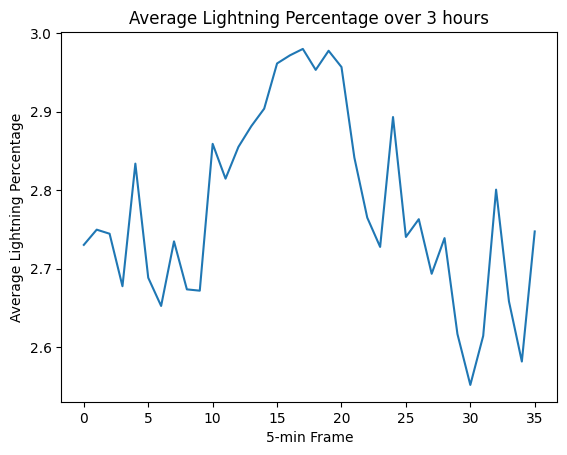

In [21]:
frame_percentage_lists = df_filtered['Frame_Lightning_Percentage'].tolist()

# Convert to a 2D NumPy array for easy computation
frame_percentage_array = np.array(frame_percentage_lists)

# Compute the mean percentage for each frame (axis=0)
average_frame_percentage = np.mean(frame_percentage_array, axis=0)

# Display the result as a list
average_frame_percentage.tolist()

plt.plot(average_frame_percentage)
plt.xlabel('5-min Frame')
plt.ylabel('Average Lightning Percentage')
plt.title('Average Lightning Percentage over 3 hours')
plt.show()

On average, each storm has the most number of lightning strikes in the middle of the storm - almost resembling a bell curve.

### Distribution of lightning in 5 mins frame

We also have to identify if there is any patterns in a shorter time frame (i.e. 5 mins), since we have 800 storms and 36 frame each, we have 28800 frames to analyse. To keep the analysis simple, the first storm in the list will be used as an example.

In [22]:
sample = load_event(id_list[0])
sample = pd.DataFrame(sample['lght'])

#first 5 mins
begin = sample[sample[0] <= 300]
#last 5 mins
end = sample[sample[0] >= 10500]

In [23]:
sample

,0,1,2,3,4
0,0.0,35.221024,-91.398697,97.144623,277.964905
1,0.0,35.011932,-91.927162,50.720562,251.529099
2,0.0,35.162552,-91.867744,55.068687,268.602295
3,0.0,34.954666,-92.266518,20.261250,243.241348
4,1.0,33.350700,-91.901527,64.372375,67.255501
...,...,...,...,...,...
38772,10789.0,34.324982,-91.087601,132.307999,180.527847
38773,10789.0,32.840694,-92.060982,52.909187,9.716500
38774,10789.0,32.980812,-91.671333,88.275497,27.597750
38775,10799.0,34.808228,-90.717125,162.251617,236.698776


In [24]:
begin_result = []
end_result = []
for i in range(300):
  num_rows_with_zero = (begin[0] == i).sum()
  begin_result.append(num_rows_with_zero)

for i in range(300):
  num_rows_with_zero = (end[0] == (i + 10500)).sum()
  end_result.append(num_rows_with_zero)

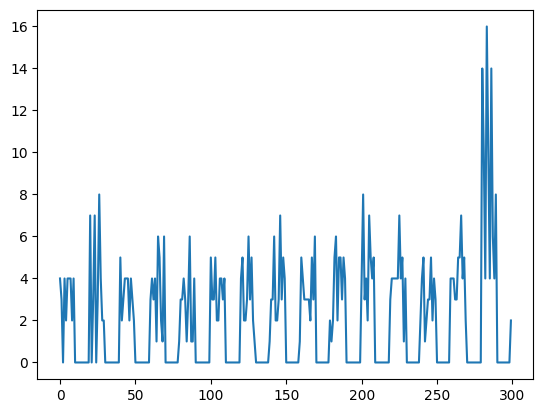

In [25]:
plt.plot(begin_result)


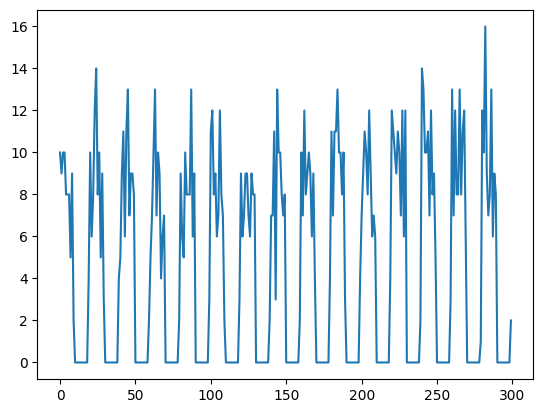

In [26]:
plt.plot(end_result)

As it's shown in plots above, the lightning follows a 'pulsing' pattern. Our goal would be to train a model that identify the pattern. The number of lightning in each pulse varies a lot and it almost seems random, at least from the prespetive of the plots above.

To train the model, we used the first and the last frame of 700 storms.

In [28]:
input = []
label = []
num_samples = 300
for sample in range(num_samples):
  id = id_list[sample]
  event = load_event(id)
  light_event = pd.DataFrame(event['lght'])
  begin_result = []
  end_result = []

  begin = light_event[light_event[0] <= 300]
  end = light_event[light_event[0] >= 10500]

  for i in range(300):
    num_rows_with_zero = (begin[0] == i).sum()
    begin_result.append(num_rows_with_zero)

  for i in range(300):
    num_rows_with_zero = (end[0] == (i + 10500)).sum()
    end_result.append(num_rows_with_zero)


  input.append(np.array([sum(begin_result)]))
  label.append(np.array(begin_result))
  input.append(np.array([sum(end_result)]))
  label.append(np.array(end_result))


input = np.array(input)
label = np.array(label)

print(input.shape)
print(label.shape)

(600, 1)
(600, 300)


For the predicted distribution, there are 3 mains constrains when traiing the model:
1. the final output must be all integers
2. the output must be all positive
3. the sum of the output must equal to the input value

For this model, 2 types of networks were tried and they were FNN and LSTM. FNN showed good result, however, LSTM is able to more consistently satisfly the constrains, especially matching the input value.

In the model design process, to match the input value, one way was to normalise the output into a probability distribution, then multiply the distribution by the input value, so that the sum would match up, However, this method could potentially lead to non-integers in the output, which violates the other constrain.

In [32]:
class LightningDataset(Dataset):
    def __init__(self, input_data, label_data):
        """
        input_data: NumPy array of shape (n_samples, 1)
        label_data: NumPy array of shape (n_samples, 300)
        """
        self.inputs = torch.tensor(input_data, dtype=torch.float32)  # Convert to tensor
        self.labels = torch.tensor(label_data, dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
      return self.inputs[idx], self.labels[idx]

In [33]:
input_tensor = torch.tensor(input, dtype=torch.float32).to(device)
label_tensor = torch.tensor(label, dtype=torch.float32).to(device)

dataset = LightningDataset(input_tensor, label_tensor)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define DataLoader
batch_size = 4  # Adjust batch size as needed
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print("Train size:", train_size)
print("Validation size:", val_size)

Train size: 480
Validation size: 120


<ipython-input-32-513628649f38>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inputs = torch.tensor(input_data, dtype=torch.float32)  # Convert to tensor
<ipython-input-32-513628649f38>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(label_data, dtype=torch.float32)


In [34]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.attention = nn.Linear(hidden_size, 1)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

        # Batch Normalization for stability
        #self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        batch_size = x.shape[0]

        # Expand input for LSTM (batch_size, sequence_length=1, input_size)
        x = x.unsqueeze(1)

        # Pass through LSTM
        lstm_out, _ = self.lstm(x)  # Output shape: (batch_size, 1, hidden_size)
        lstm_out = lstm_out[:, -1, :]  # Take last time step output

        # Fully connected layer
        raw_output = self.fc(lstm_out)  # Shape: (batch_size, output_size)

        # Normalize output to ensure sum = 1
        normalized_output = raw_output / torch.clamp(raw_output.sum(dim=1, keepdim=True), min=1e-6)

        # Scale by input value
        scaled_output = normalized_output * x.squeeze(1)  # Enforce sum(output) = input

        # STE: Differentiable rounding using (x - detach(x)) + round(x)
        int_output = (scaled_output - scaled_output.detach()) + torch.round(scaled_output)

        # Compute sum difference
        diff = (x.squeeze(1) - int_output.sum(dim=1, keepdim=True)).long()

        # Distribute `diff` efficiently
        residuals = scaled_output - int_output
        indices = torch.argsort(residuals, descending=True)

        for i in range(int_output.shape[0]):  # Batch loop
            if diff[i] > 0:
                int_output[i, indices[i][:diff[i]]] += 1  # Add to top `diff[i]` values

        return int_output.clamp(min=0)  # Ensure no negatives

In [35]:
num_features = 1  # Single input feature (lightning count)
num_outputs = 300

model = LSTMModel(input_size=num_features, hidden_size=128, output_size=num_outputs, num_layers=2).to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training parameters
epochs = 50
liveloss = PlotLosses()

# Training loop with real-time loss visualization
train_losses = []
val_losses = []

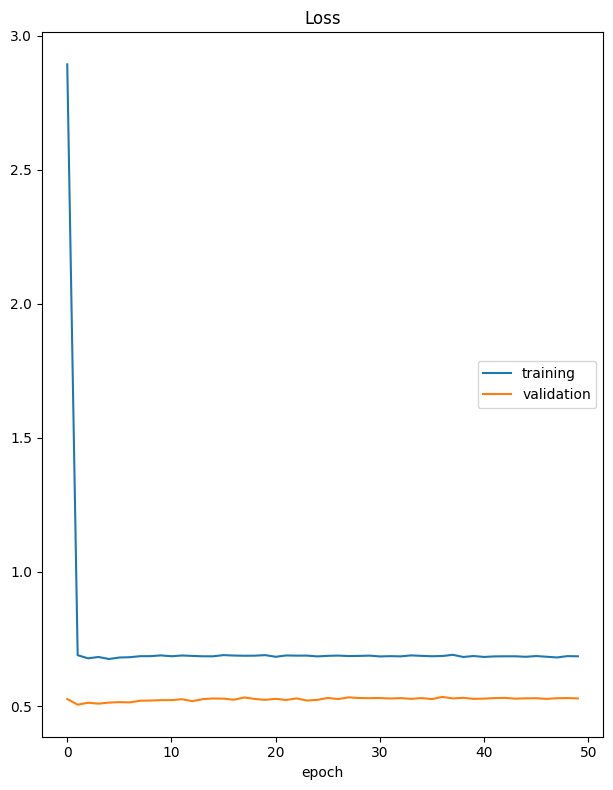

Loss
	training         	 (min:    0.676, max:    2.893, cur:    0.686)
	validation       	 (min:    0.505, max:    0.534, cur:    0.529)


In [36]:
for epoch in range(epochs):
    logs = {}

    # Training phase
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)  # Forward pass
        loss = criterion(y_pred, y_batch)  # Compute loss
        loss.backward()  # Backpropagation
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()  # Update weights
        train_loss += loss.item()

    scheduler.step()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    logs['loss'] = train_loss  # Log training loss

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    logs['val_loss'] = val_loss  # Log validation loss

    liveloss.update(logs)
    liveloss.send()

For this part of the task only a very simple model was used, because the pattern was straight forward to identify.

## Final model

Lastly, the 2 models can be used in together to give a desired prediction.

Combining the result from the location prediction model with the time model:

In [37]:
model_path = "/content/drive/MyDrive/lstm_full_model3.pth"
time_model = torch.load(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
time_model.to(device)
time_model.eval()

<ipython-input-37-67e6cdaf06d7>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  time_model = torch.load(model_path)


LSTMModel(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (attention): Linear(in_features=128, out_features=1, bias=True)
  (fc): Linear(in_features=128, out_features=300, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [41]:
model_path = "/content/drive/MyDrive/location_prediction.pth"
model = torch.load(model_path)
model.to(device)
model.eval()

<ipython-input-41-c0cc3b3d9ad2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


SimpleLightningStrikeCNN3D(
  (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4): Conv3d(64, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

Load the next batch to the location model to get the model output.

In [72]:
with torch.no_grad():
    # Pick the first sample from the validation set
    valid_sample, valid_target = next(iter(val_loader))
    valid_sample = valid_sample.to(device)
    valid_target = valid_target.to(device)
    # Get model output
    output_sample = model(valid_sample)
output_sample.shape

torch.Size([16, 36, 192, 192])

Since the location only gives prediction in the grid of 192 x 192, the gird has to be scaled up - to do so, the x and y coordinates are multiplied by 2.

Batch 0, Time 1 - Number of Strikes: 13
Scaled X Coords: [68, 68, 70, 68, 70, 72, 66, 68, 70, 72, 68, 70, 72]
Scaled Y Coords: [112, 114, 114, 116, 116, 116, 118, 118, 118, 118, 120, 120, 120]


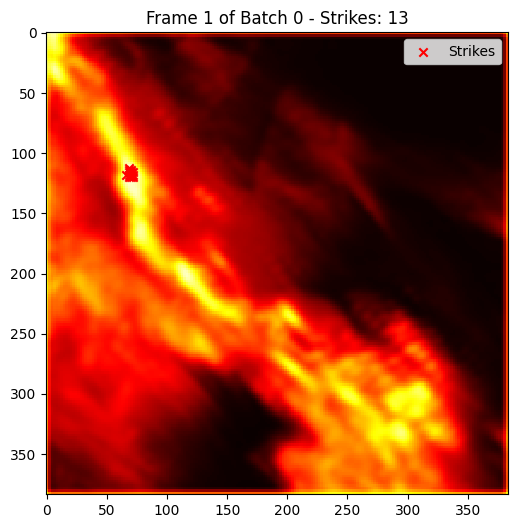

In [45]:
# Initialize an empty dictionary to store scaled strike coordinates
strike_locations_per_frame = {}

# Iterate over batches and time steps to extract and scale x, y coordinates
for batch_idx in range(16):  # Loop over batch dimension
    for time_idx in range(36):  # Loop over time steps
        frame = output_sample[batch_idx, time_idx].cpu().detach().numpy()
        y_coords, x_coords = np.where(frame > 0)  # Get coordinates where value > 0

        # Scale coordinates by a factor of 2 for 384x384 resolution
        scaled_x_coords = (x_coords * 2).tolist()
        scaled_y_coords = (y_coords * 2).tolist()

        # Store coordinates as a tuple of arrays
        strike_locations_per_frame[(batch_idx, time_idx)] = {
            "x": scaled_x_coords,  # Scaled X coordinates
            "y": scaled_y_coords,  # Scaled Y coordinates
        }

# Example: Retrieve scaled x, y coordinates for a specific batch and time step
batch_idx = 0
time_idx = 1
example_coords = strike_locations_per_frame[(batch_idx, time_idx)]
print(f"Batch {batch_idx}, Time {time_idx} - Number of Strikes: {len(example_coords['x'])}")
print(f"Scaled X Coords: {example_coords['x']}")
print(f"Scaled Y Coords: {example_coords['y']}")

# Optional: Visualize the scaled strike locations
target_frame = np.kron(output_sample[batch_idx, time_idx].cpu().detach().numpy(), np.ones((2, 2)))  # Upscale frame to 384x384
plt.figure(figsize=(6, 6))
plt.imshow(target_frame, cmap='hot', interpolation='nearest')
plt.scatter(example_coords["x"], example_coords["y"], marker='x', color='red', label='Strikes')
plt.title(f"Frame {time_idx} of Batch {batch_idx} - Strikes: {len(example_coords['x'])}")
plt.legend()
plt.show()

Again, the plot above shows the location of the strikes.  The number of strikes can also be found by counting the number of locations. Next we can turn the result into time series by passing it through the time model.

In [46]:
def extract_lightning_strikes(strike_locations_per_frame, time_model, device="cuda:0", batch_range=(0,1), num_time_steps=36):
    """
    Extracts lightning strike data from predicted time distributions and detected strikes.

    Parameters:
        batch_range (tuple): Start and end batch indices (e.g., (0, 1)).
        num_time_steps (int): Number of time steps to process.
        strike_locations_per_frame (dict): Dictionary containing detected strike locations.
        time_model (torch.nn.Module): Model predicting time distribution of strikes.
        device (str): Device for model inference (default: "cuda:0").

    Returns:
        pd.DataFrame: DataFrame containing extracted lightning strike data.
    """
    strike_data = []
    temp = 0  # Total detected strikes

    for batch_idx in range(batch_range[0], batch_range[1]):
        for time_idx in range(num_time_steps):
            current_frame_cords = strike_locations_per_frame[(batch_idx, time_idx)]
            current_frame_number = len(current_frame_cords['x'])
            temp += current_frame_number  # Track total strikes

            # Get predicted time step(s) from the time model
            time_tensor = torch.tensor([[current_frame_number]], dtype=torch.float32).to(device)
            current_frame_time_distribution = time_model(time_tensor)

            # Extract indices where the output is nonzero (i.e., predicted lightning events)
            predicted_time_steps = torch.nonzero(current_frame_time_distribution.squeeze() > 0).squeeze().cpu().numpy()

            # Ensure predicted_time_steps is iterable (convert scalar to list if needed)
            if predicted_time_steps.ndim == 0:
                predicted_time_steps = [int(predicted_time_steps)]
            else:
                predicted_time_steps = predicted_time_steps.tolist()

            # If no time step is predicted, assign to a default time step
            if len(predicted_time_steps) == 0:
                predicted_time_steps = [0]  # Default to the first available time step

            # Maintain a set to track already assigned time steps
            assigned_time_steps = set()

            # Store each lightning strike with its x, y, and non-repeated predicted time steps
            for x, y in zip(current_frame_cords['x'], current_frame_cords['y']):
                assigned = False  # Track if the (x, y) was assigned

                for predicted_time_step in predicted_time_steps:
                    if predicted_time_step not in assigned_time_steps:
                        strike_data.append({
                            "t": float(predicted_time_step + time_idx * 5 * 60),  # Unique per (x, y)
                            "vil pixel x": x,
                            "vil pixel y": y
                        })
                        assigned_time_steps.add(predicted_time_step)  # Mark as used
                        assigned = True  # Mark as successfully assigned
                        break  # Move to next (x, y) to avoid duplication

                # If no predicted time step was assigned, assign to the first available time step
                if not assigned:
                    strike_data.append({
                        "t": float(predicted_time_steps[0] + time_idx * 5 * 60),
                        "vil pixel x": x,
                        "vil pixel y": y
                    })

    # Convert to Pandas DataFrame
    strike_df = pd.DataFrame(strike_data)
    print("Total detected strikes (temp):", temp)
    print("Total rows in DataFrame:", len(strike_df))

    return strike_df


strike_df = extract_lightning_strikes(strike_locations_per_frame, time_model, device="cuda:0")
strike_df


Total detected strikes (temp): 1099
Total rows in DataFrame: 1099


,t,vil pixel x,vil pixel y
0,313.0,68,112
1,336.0,68,114
2,349.0,70,114
3,353.0,68,116
4,370.0,70,116
...,...,...,...
1094,7974.0,188,130
1095,7993.0,190,130
1096,8051.0,188,132
1097,8061.0,190,132
